In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime
import os
from pyspark.sql.functions import to_date
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dir = '/content/drive/My Drive/HSBC'

In [4]:
spark = SparkSession.builder \
    .appName("Stocks Data Analysis") \
    .getOrCreate()

In [5]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [6]:
# Schemat dla plików CSV
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Close", DoubleType(), True)
])

In [7]:
def process_file(file_path, n_steps):
    df = spark.read.csv(file_path, schema=schema, header=False)

    df = df.withColumn("Symbol", F.input_file_name()) \
        .withColumn("Symbol", F.element_at(F.split(F.col("Symbol"), "\\."), 1))

    df = df.withColumn('count', F.count("Symbol").over(Window.partitionBy('Symbol')))

    df = df.withColumn("Date", F.to_date(F.to_timestamp(F.col('Date'), 'yy-MM-dd')))
    df = df.filter(F.col("Date") >= datetime(2019, 1, 2)) \
           .filter(F.col('Date') <= datetime(2024, 12, 30))

    # Funkcja do obliczania zwrotu (rolling window)
    window = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(1 - n_steps, 0)
    df = df.withColumn("return", \
                       (F.col("Close") - F.first("Close").over(window)) / F.first("Close").over(window))

    return df.orderBy("Symbol", "Date")

Liczba kroków jest równa 100 i jest to okno dwudziestu tygodni (giełda nie jest otwarta w weekedy). Obliczanie zwrotu z inwestycji dla każdego symbolu akcji w oknie czasowym o długości n_steps, a wynik jest dodawany do final_df. Teraz dane mogą być przetwarzane dalej lub eksportowane. Exportujemy dane do PandasDataFrame

In [8]:
# Obliczany jest zwrot z inwestycji (return) jako procentowa zmiana wartości w oknie czasowym o długości n_steps dni.
# Używane są okna czasowe (Window), które grupują dane według Symbol i sortują według daty.
n_steps = 100

all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

dataframes = {}
for file_path in all_files:
    # Klucz w słowniku to nazwa pliku bez rozszerzenia
    file_name = os.path.basename(file_path).split('.')[0]
    dataframes[file_name] = process_file(file_path, n_steps)

# Przykład dostępu do poszczególnych DataFrame'ów
for symbol, df in dataframes.items():
    print(f"Symbol: {symbol}")
    df.show(5)

Symbol: S&P_500_historical_data
+----------+-----------------+--------------------+-----+--------------------+
|      Date|            Close|              Symbol|count|              return|
+----------+-----------------+--------------------+-----+--------------------+
|2019-01-02|  2476.9599609375|file:///content/d...| 1512|                 0.0|
|2019-01-03|   2491.919921875|file:///content/d...| 1512|0.006039645845481423|
|2019-01-04|   2474.330078125|file:///content/d...| 1512|-0.00106173812010...|
|2019-01-07|2535.610107421875|file:///content/d...| 1512|0.023678277973527118|
|2019-01-08|2568.110107421875|file:///content/d...| 1512| 0.03679920060148076|
+----------+-----------------+--------------------+-----+--------------------+
only showing top 5 rows

Symbol: Dow_Jones_historical_data
+----------+---------------+--------------------+-----+--------------------+
|      Date|          Close|              Symbol|count|              return|
+----------+---------------+----------------

In [9]:
symbol = "S&P_500_historical_data"
for symbol in dataframes:
    final_df = dataframes[symbol]

    pandas_df = final_df.toPandas()

    pandas_df = pandas_df.assign(stock_returns=pandas_df['Close'])

    print(pandas_df.head())

         Date        Close                                             Symbol  \
0  2019-01-02  2476.959961  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
1  2019-01-03  2491.919922  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
2  2019-01-04  2474.330078  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
3  2019-01-07  2535.610107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
4  2019-01-08  2568.110107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   

   count    return  stock_returns  
0   1512  0.000000    2476.959961  
1   1512  0.006040    2491.919922  
2   1512 -0.001062    2474.330078  
3   1512  0.023678    2535.610107  
4   1512  0.036799    2568.110107  
         Date         Close  \
0  2019-01-02  23058.609375   
1  2019-01-03  23176.390625   
2  2019-01-04  22894.919922   
3  2019-01-07  23474.259766   
4  2019-01-08  23680.320312   

                                              Symbol  count    return  \
0  file:///content/drive/My%20Drive/H

VaR calculated directly from historical returns

In [10]:
def historical_var(returns, alpha=0.01):
    return np.percentile(returns, 100 * alpha)

for symbol in dataframes:
    final_df = dataframes[symbol]
    var_historical = historical_var(final_df.toPandas()['return'])
    print(var_historical)

-0.1739988791015994
-0.19418574875496994
-0.24648615473926788
-0.15411615596075348


In [11]:
def gaussian_var(returns, confidence_level=0.99):

    mean = np.mean(returns)
    std_dev = np.std(returns)
    z_score = norm.ppf(1 - confidence_level)
    var = -(mean + z_score * std_dev)
    return var
for symbol in dataframes:
    final_df = dataframes[symbol]
    var_result = gaussian_var(final_df.toPandas()['return'])
    print(var_result)

0.1557575124860967
0.15982007251124378
0.2105763751373881
0.1812635067603467


In [13]:
def ewma_volatility(returns, lambda_=0.94):

    weights = np.array([(1 - lambda_) * lambda_ ** i for i in range(len(returns))][::-1])
    ewma_variance = np.sum(weights * (returns ** 2))
    return np.sqrt(ewma_variance)

def filtered_var(returns, confidence_level=0.99, lambda_=0.94):

    ewma_vol = ewma_volatility(returns, lambda_)
    z_score = norm.ppf(1 - confidence_level)
    mean = np.mean(returns)
    var = -(mean + z_score * ewma_vol)
    return var

for symbol in dataframes:
    final_df = dataframes[symbol]
    var_result = filtered_var(final_df.toPandas()['return'])
    print(var_result)

0.1823532673486239
0.18366392052775612
0.04426597683627879
0.3195868190138446


Different lookback periods and VaR for each day with respect to different look-back periods

In [14]:
def historical_var_periods(dataframes, lookback_periods, alpha=0.01):
    var_results = {}

    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = data['Close'].pct_change()
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:

            rolling_returns = data['return'].rolling(period)
            var_series = rolling_returns.apply(lambda x: np.percentile(x, 100 * alpha), raw=True)
            var_series.dropna(inplace=True)
            var_results[symbol][period] = var_series

    return var_results

In [15]:
lookback_periods = [10, 50, 100, 250,500]
var_results = historical_var_periods(dataframes, lookback_periods=lookback_periods, alpha=0.01)
os.makedirs(input_dir, exist_ok=True)
for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series.head())

Symbol: S&P_500_historical_data, Lookback: 10 days
10   -0.006695
11   -0.006695
12   -0.002969
13   -0.002969
14   -0.005201
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
50   -0.011127
51   -0.011127
52   -0.011127
53   -0.011127
54   -0.011127
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
100   -0.012960
101   -0.014086
102   -0.014086
103   -0.014086
104   -0.014086
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
250   -0.016816
251   -0.016816
252   -0.016816
253   -0.016816
254   -0.016816
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 500 days
500   -0.033123
501   -0.033123
502   -0.033123
503   -0.033123
504   -0.033123
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 10 days
10   -0.011275
11   -0.011275
12   -0.002386
13   -0.002386
14   -0.002386
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 50 da

In [44]:
output_dir = "/content/drive/My Drive/HSBC/csvs"
os.makedirs(output_dir, exist_ok=True)

for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        filename = f"{symbol}_lookback_{period}_days.csv"
        filepath = os.path.join(output_dir, filename)

        series.to_csv(filepath, index=True)
        print(f"Saved: {filepath}")

Saved: /content/drive/My Drive/HSBC/csvs/S&P_500_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/S&P_500_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/S&P_500_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/S&P_500_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/S&P_500_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Dow_Jones_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Dow_Jones_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Dow_Jones_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Dow_Jones_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Dow_Jones_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/csvs/Euro_Stoxx_50_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/H

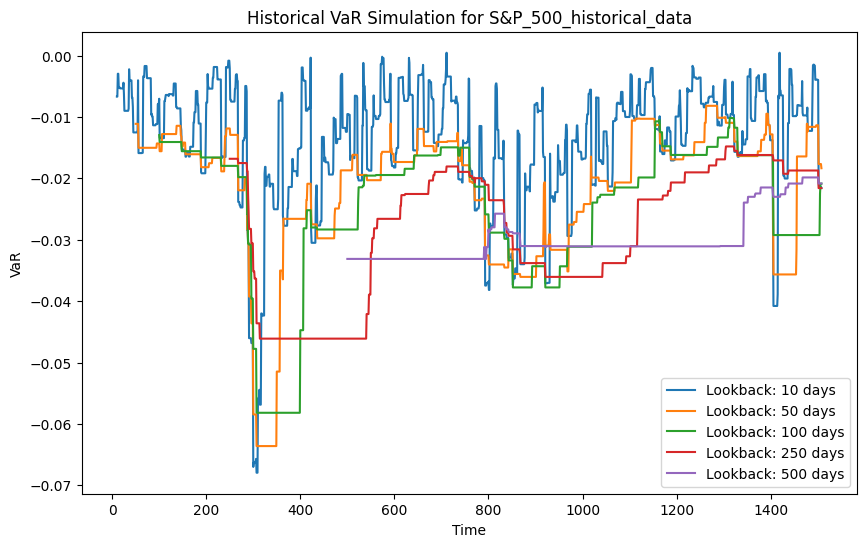

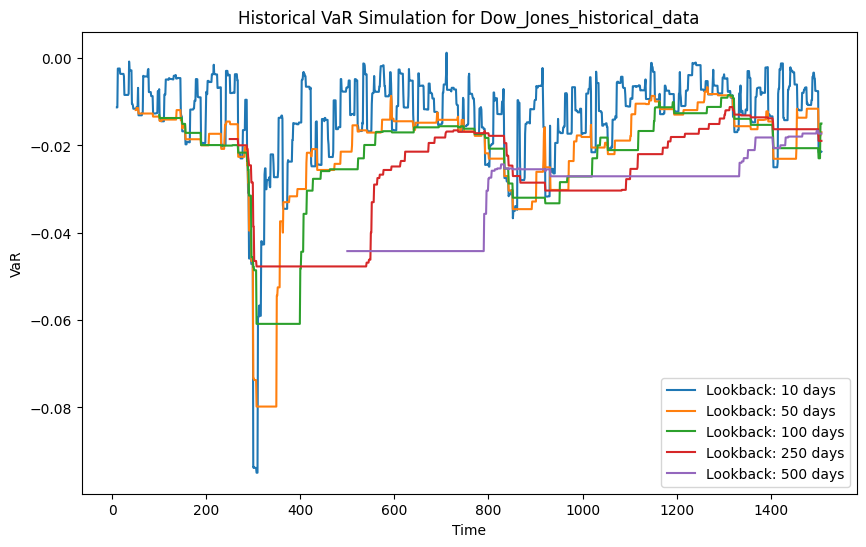

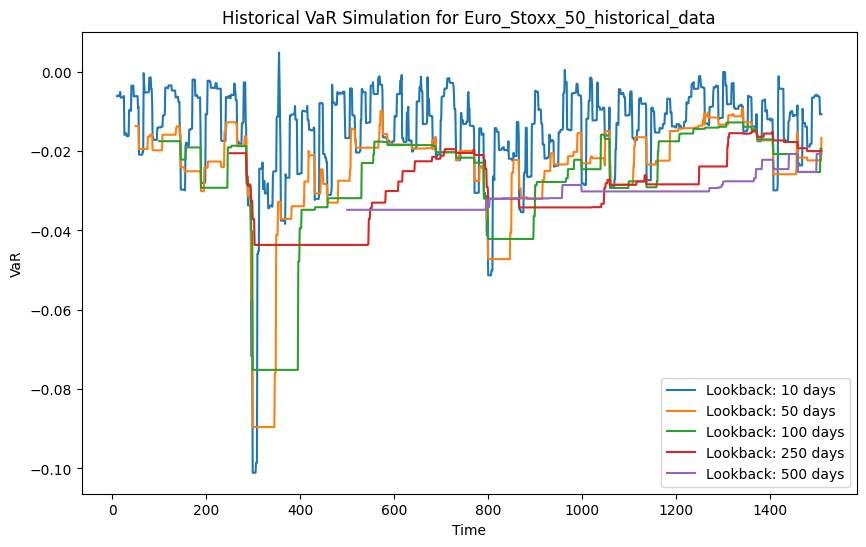

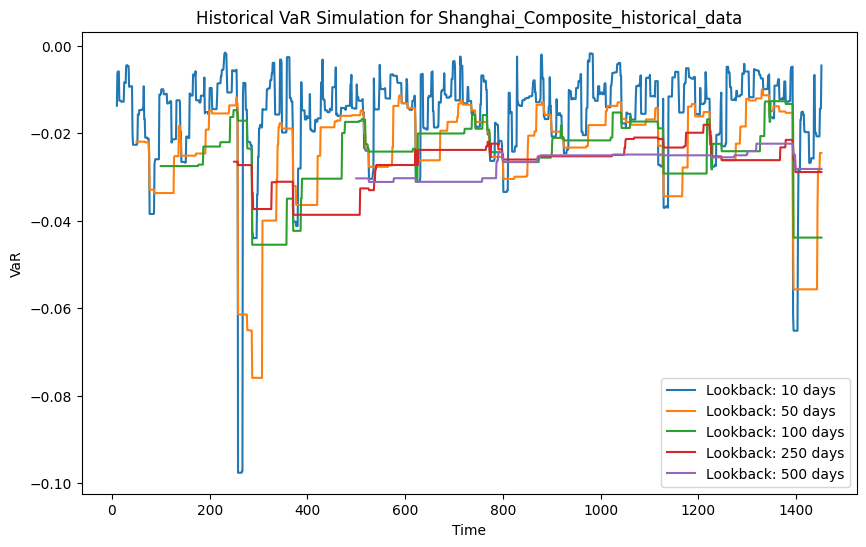

In [16]:
for symbol, period_results in var_results.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Historical VaR Simulation for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()
    plt.show()

In [47]:
output_folder = "/content/drive/My Drive/HSBC/obrazki"

os.makedirs(output_folder, exist_ok=True)

for symbol, period_results in var_results.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Historical VaR Simulation for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()

    output_path = os.path.join(output_folder, f'{symbol}_VaR_plot.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

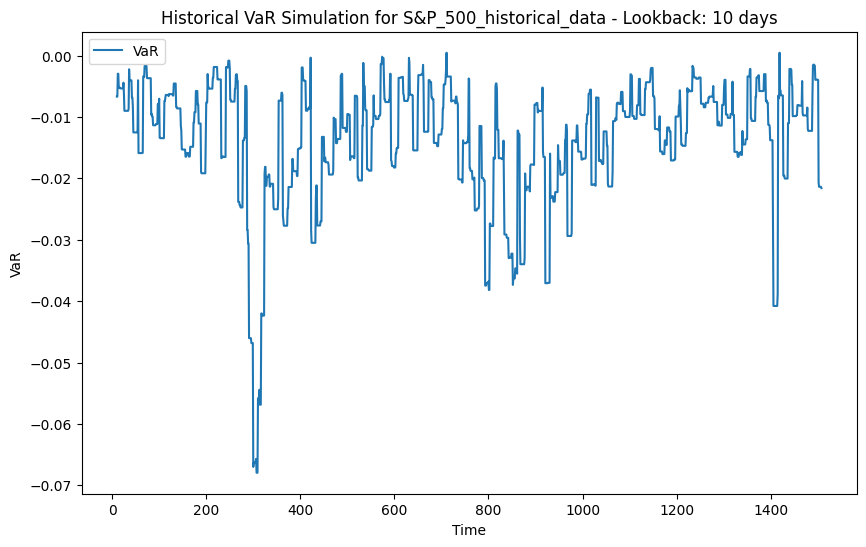

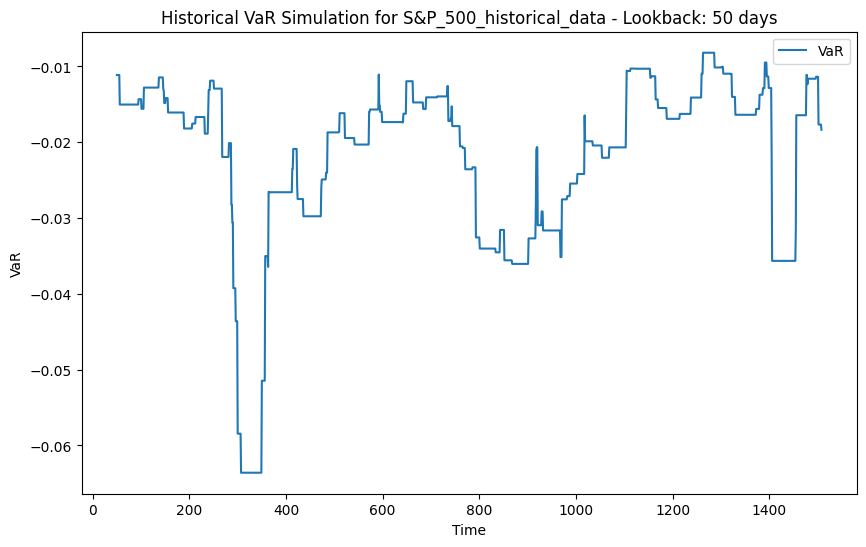

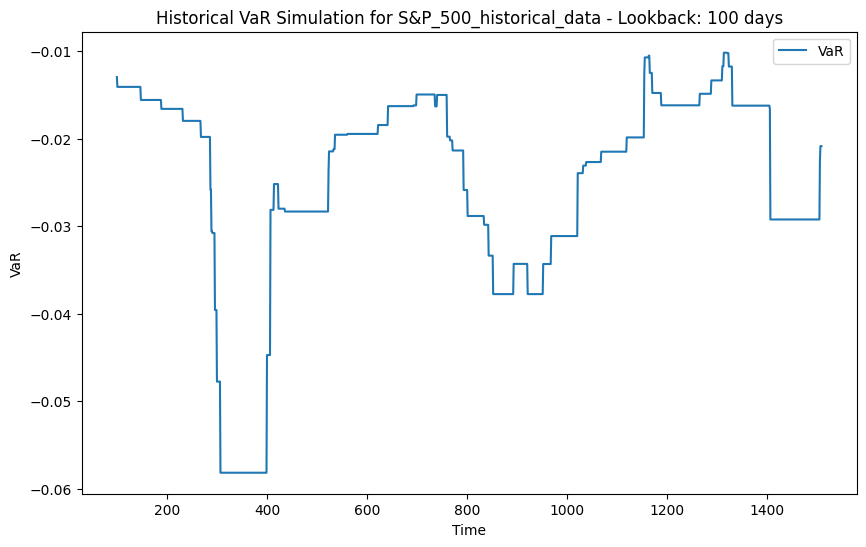

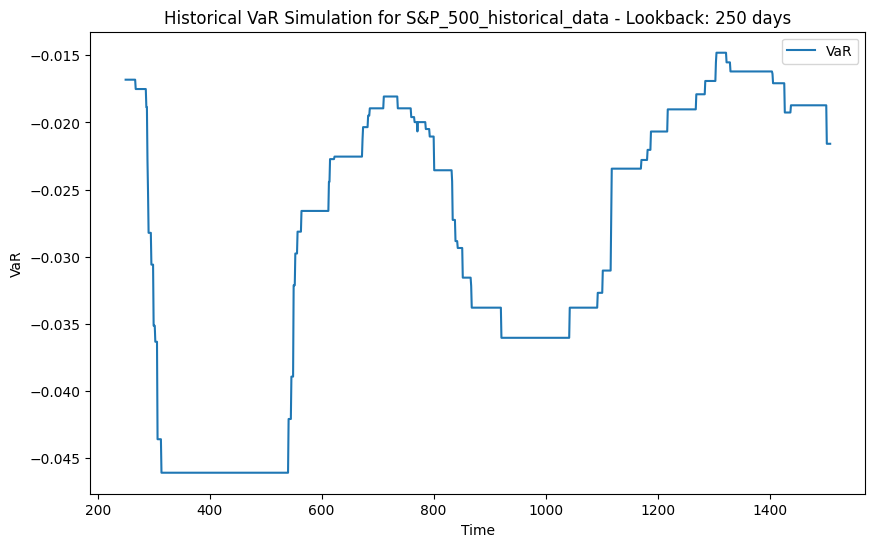

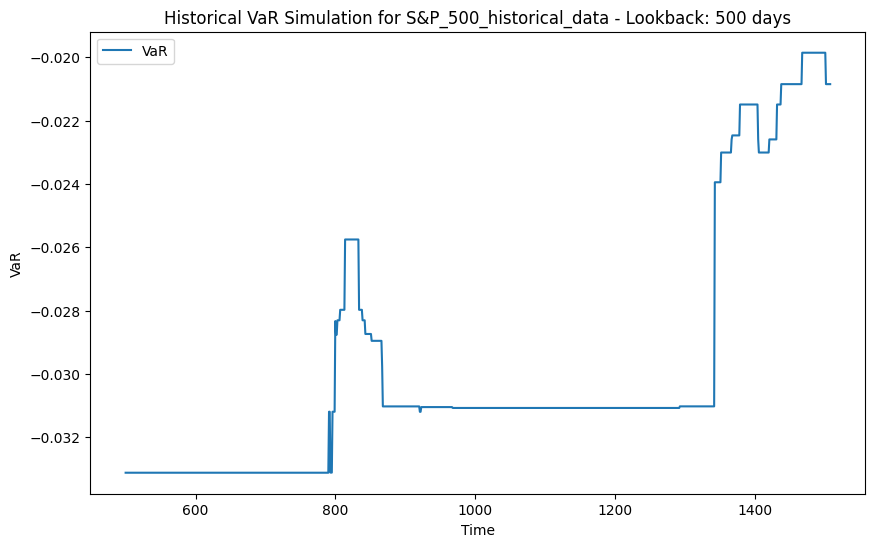

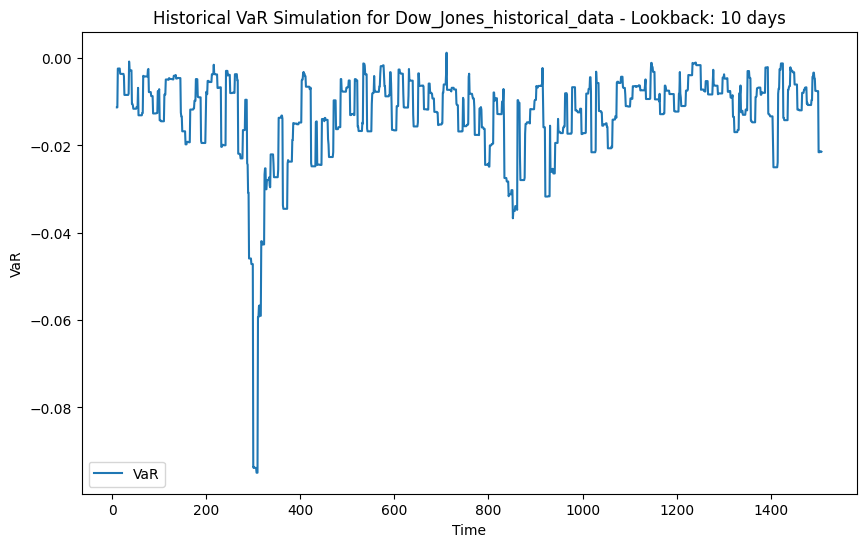

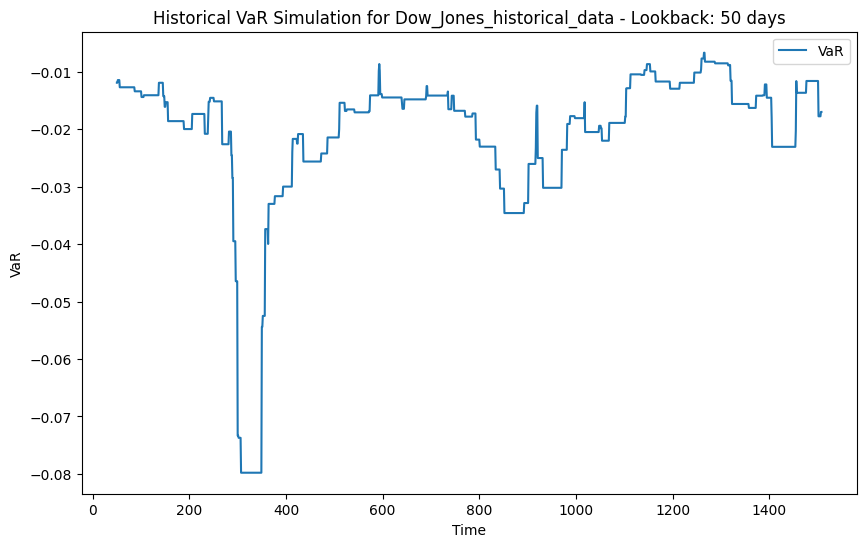

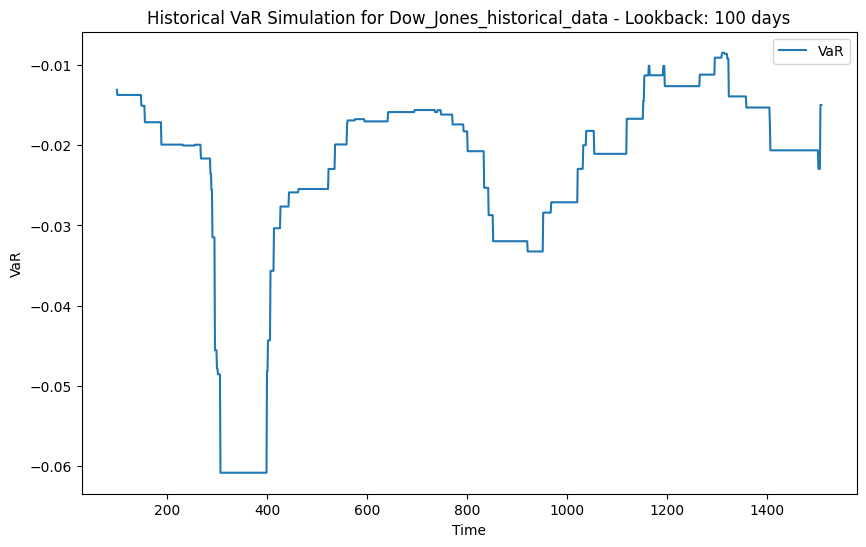

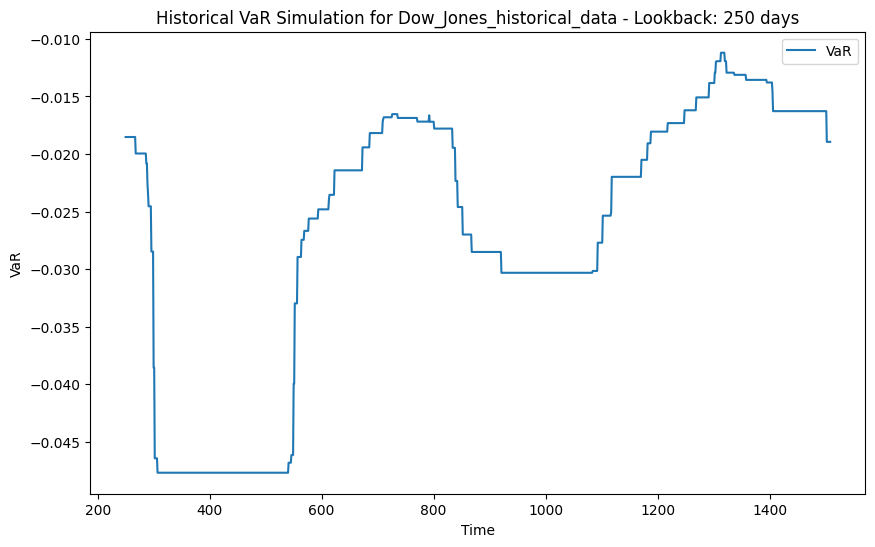

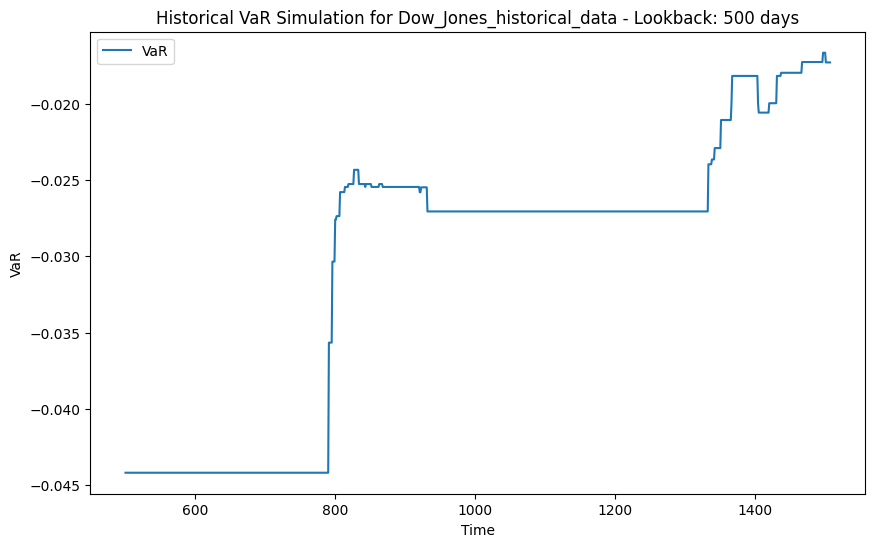

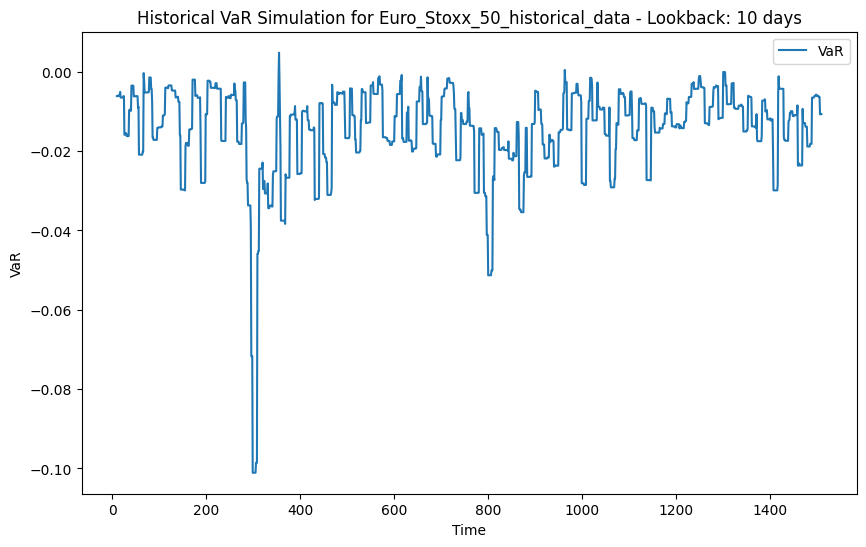

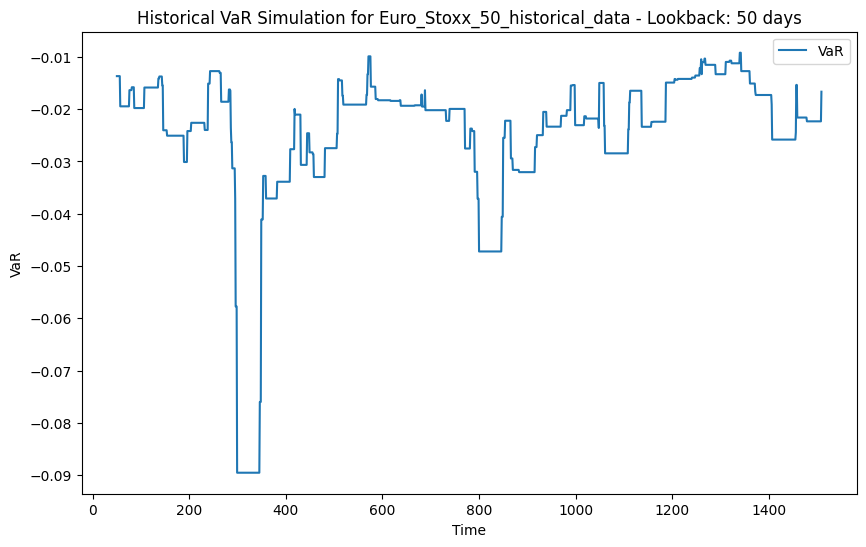

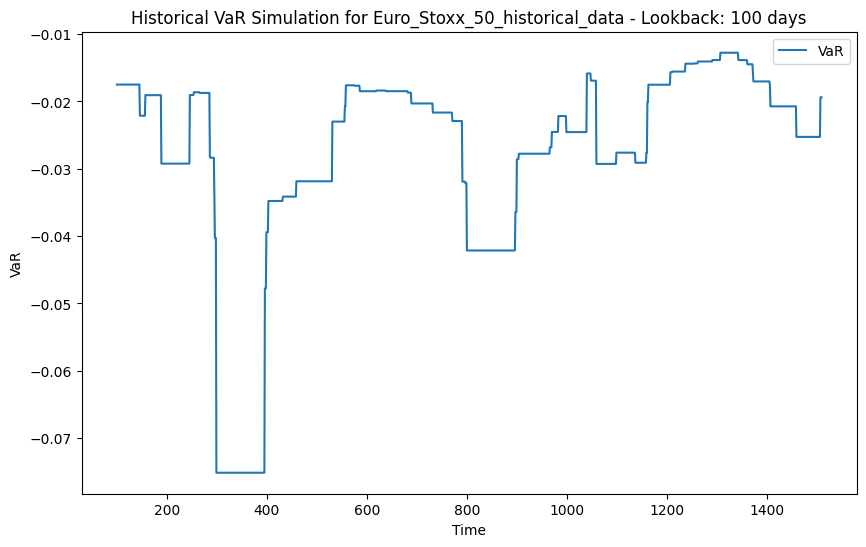

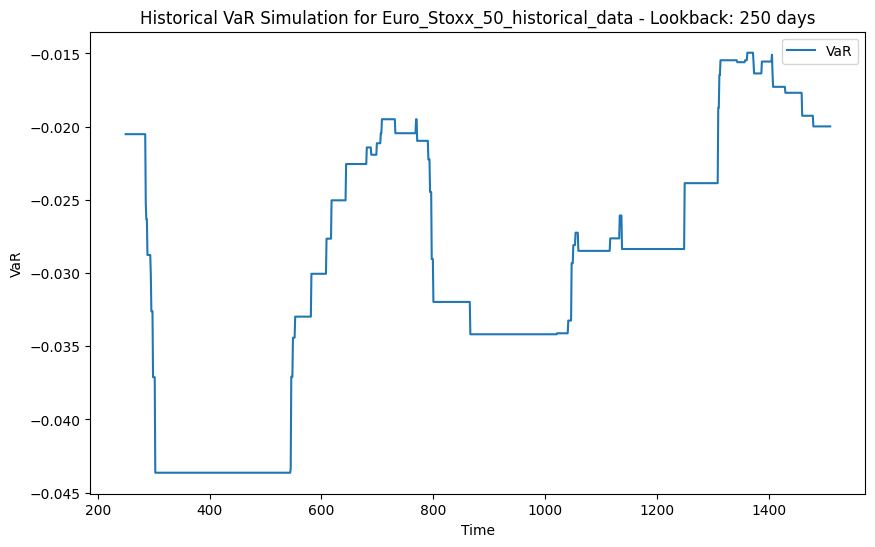

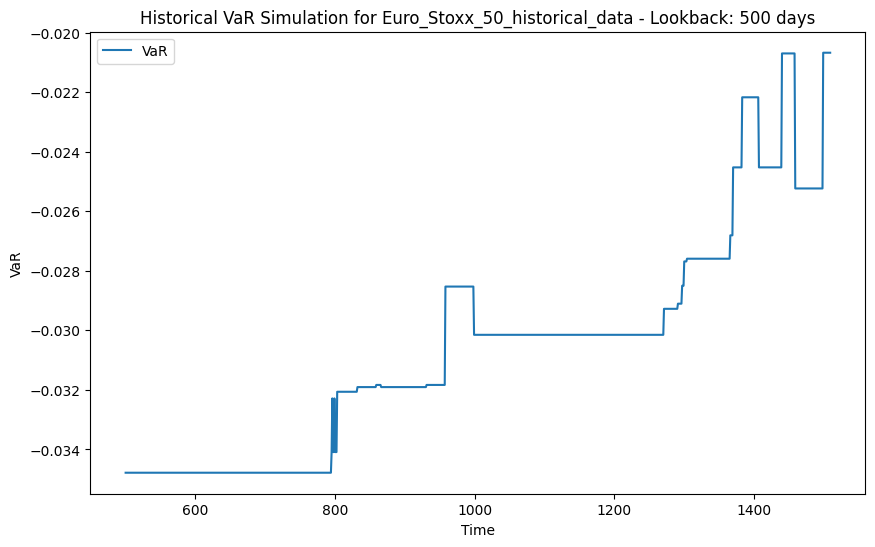

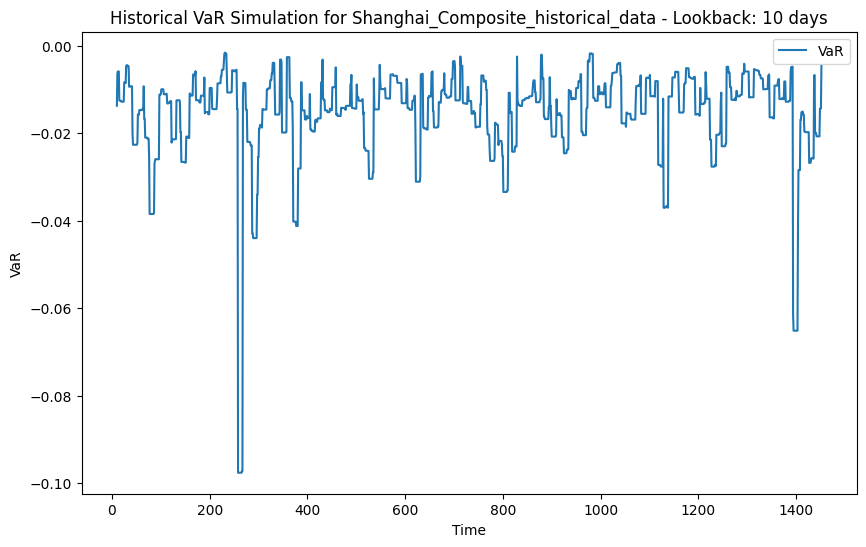

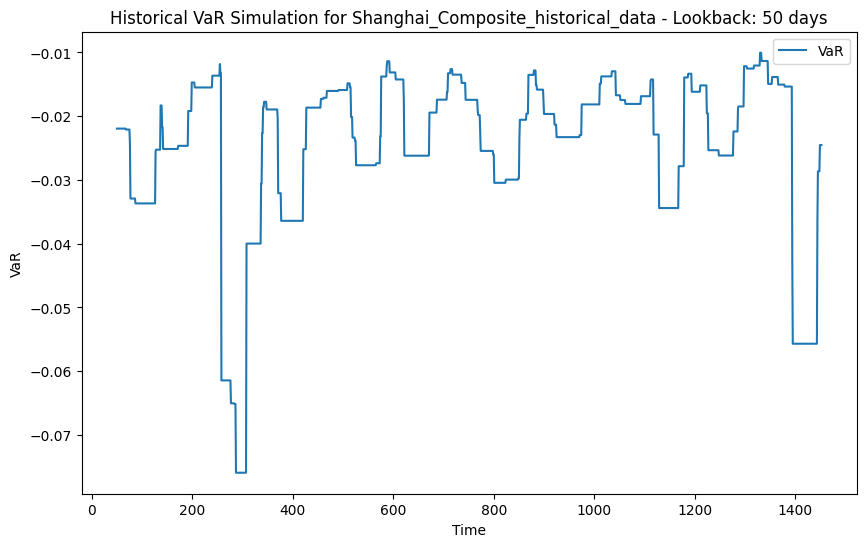

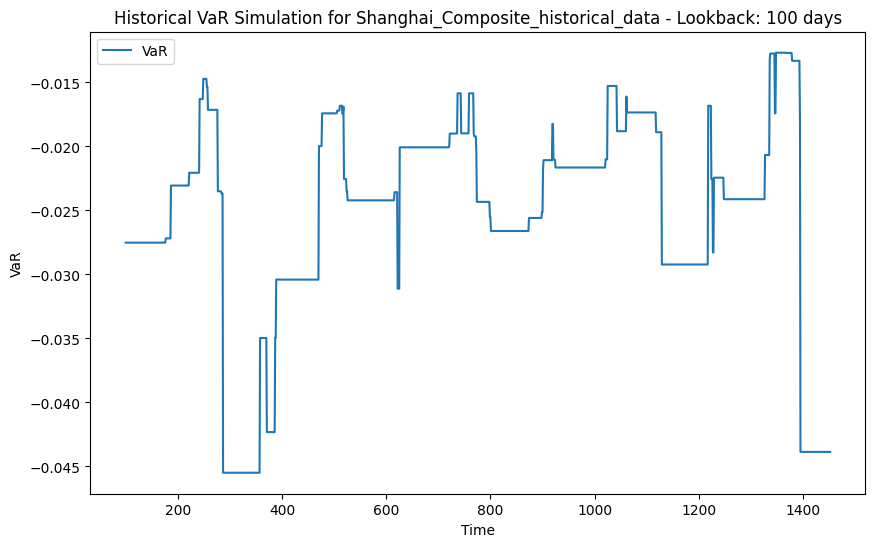

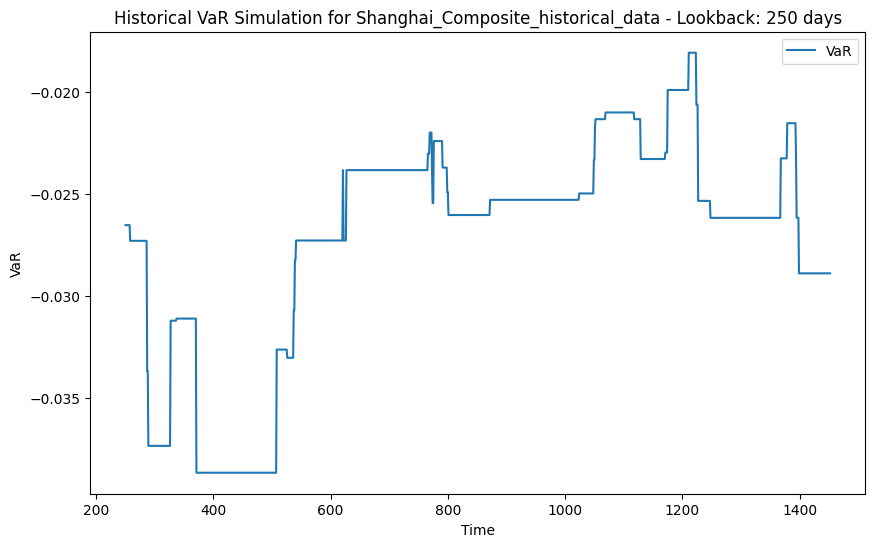

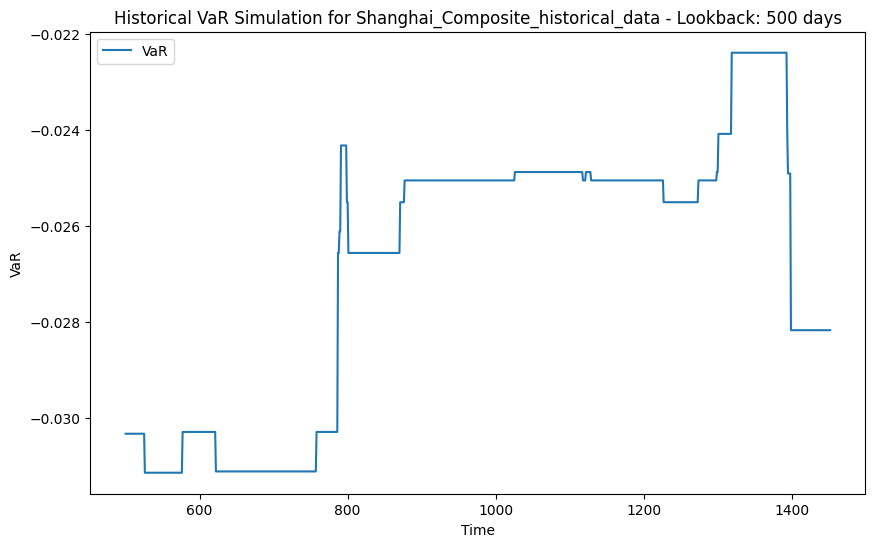

<ipython-input-48-062a55a8609b>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [48]:
for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label=f'VaR')
        plt.title(f'Historical VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()
        plt.show()
        plt.close()

In [49]:
output_folder = "/content/drive/My Drive/HSBC/obrazki"

os.makedirs(output_folder, exist_ok=True)

for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label='VaR')
        plt.title(f'Historical VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()

        output_path = os.path.join(output_folder, f'{symbol}_VaR_Lookback_{period}_days.png')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [17]:
def gaussian_var(dataframes, lookback_periods, confidence_level=0.99):
    z_score = abs(np.percentile(np.random.standard_normal(100000), 100 * (1 - confidence_level)))
    var_results = {}

    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = data['Close'].pct_change()
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:
            rolling_mean = data['return'].rolling(period).mean()
            rolling_std = data['return'].rolling(period).std()

            var_series = rolling_mean - z_score * rolling_std

            var_series.dropna(inplace=True)

            var_results[symbol][period] = var_series

    return var_results

In [18]:
lookback_periods = [10, 50, 100, 250,500]
confidence_level = 0.99

var_results3 = gaussian_var(dataframes, lookback_periods=lookback_periods, confidence_level=confidence_level)

for symbol, period_results in var_results3.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series)


Symbol: S&P_500_historical_data, Lookback: 10 days
10     -0.016068
11     -0.017572
12     -0.014429
13     -0.011040
14     -0.012954
          ...   
1504   -0.025598
1505   -0.025435
1506   -0.025489
1507   -0.025980
1508   -0.029121
Name: return, Length: 1499, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
50     -0.013958
51     -0.013963
52     -0.013422
53     -0.012322
54     -0.012362
          ...   
1504   -0.016942
1505   -0.016882
1506   -0.016889
1507   -0.016557
1508   -0.017427
Name: return, Length: 1459, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
100    -0.013808
101    -0.014387
102    -0.014218
103    -0.013644
104    -0.013621
          ...   
1504   -0.020108
1505   -0.018581
1506   -0.015332
1507   -0.015368
1508   -0.015686
Name: return, Length: 1409, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
250    -0.014895
251    -0.014985
252    -0.014920
253    -0.014686
254    -0.014659
          ...   
15

In [45]:
output_dir = "/content/drive/My Drive/HSBC/Gcsvs"
os.makedirs(output_dir, exist_ok=True)

for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        filename = f"{symbol}_lookback_{period}_days.csv"
        filepath = os.path.join(output_dir, filename)

        series.to_csv(filepath, index=True)
        print(f"Saved: {filepath}")

Saved: /content/drive/My Drive/HSBC/Gcsvs/S&P_500_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/S&P_500_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/S&P_500_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/S&P_500_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/S&P_500_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Dow_Jones_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Dow_Jones_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Dow_Jones_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Dow_Jones_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Dow_Jones_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/Gcsvs/Euro_Stoxx_50_historical_data_lookback_10_days.csv
Saved: /content/drive

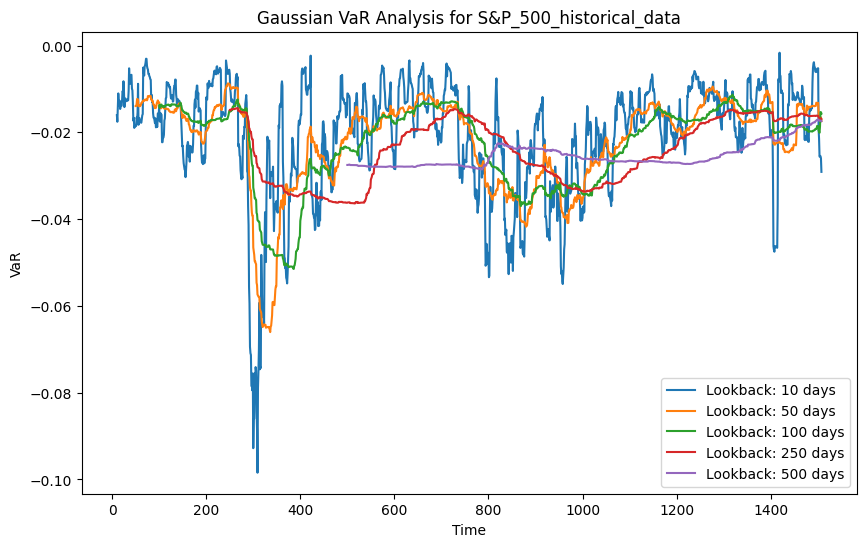

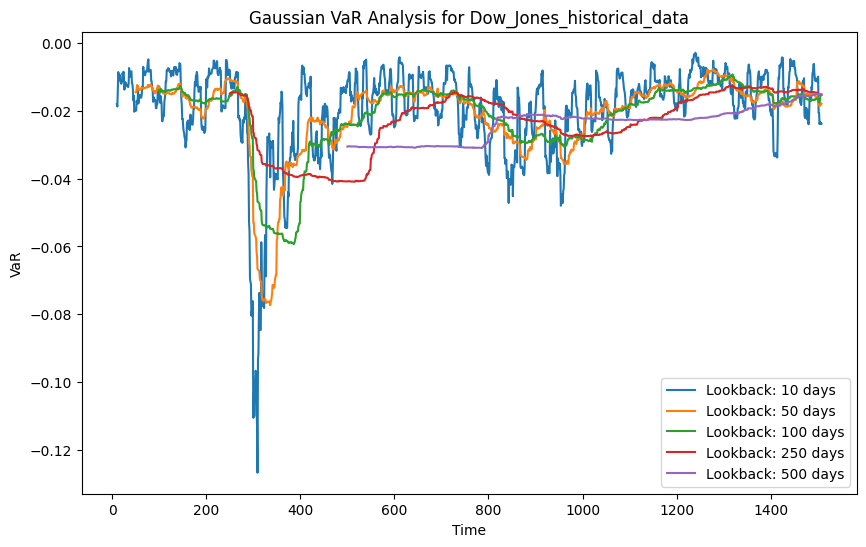

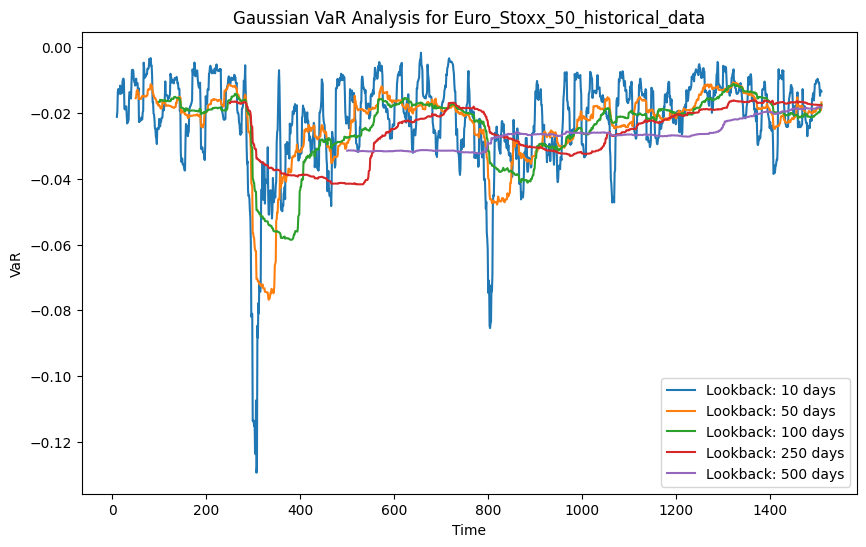

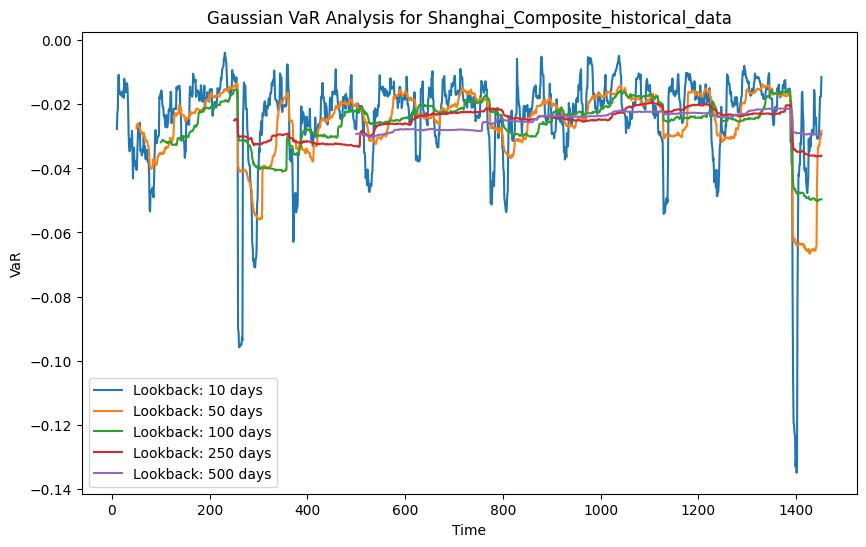

In [19]:
for symbol, period_results in var_results3.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Gaussian VaR Analysis for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()
    plt.show()

In [50]:
output_folder = "/content/drive/My Drive/HSBC/obrazki"

os.makedirs(output_folder, exist_ok=True)

for symbol, period_results in var_results3.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Gaussian VaR Analysis for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()

    output_path = os.path.join(output_folder, f'{symbol}_Gaussian_VaR_Analysis.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

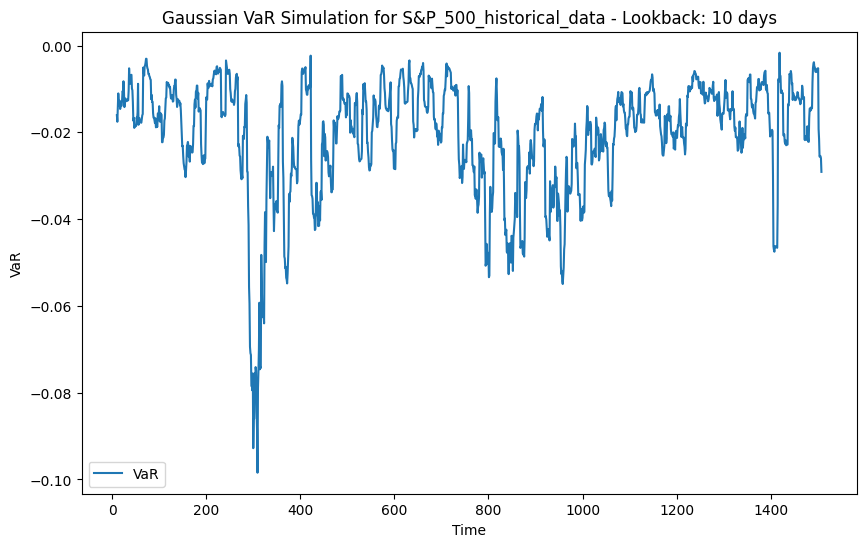

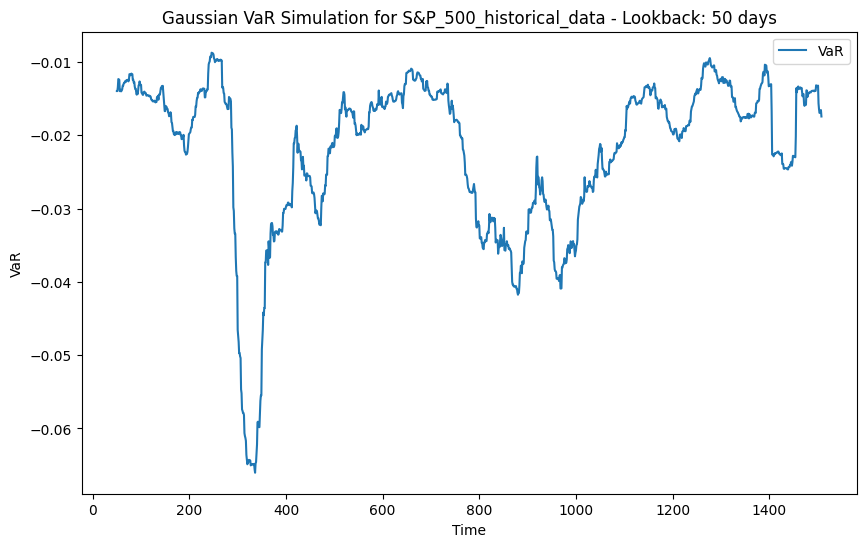

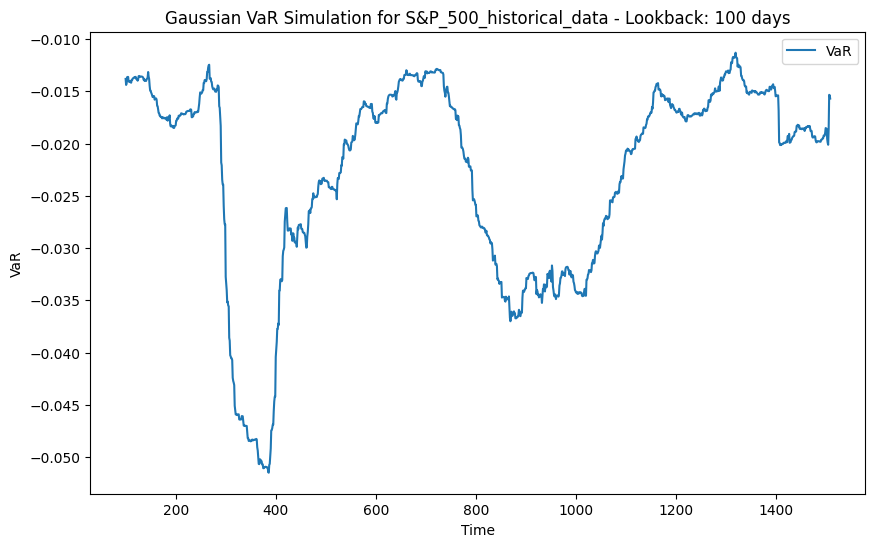

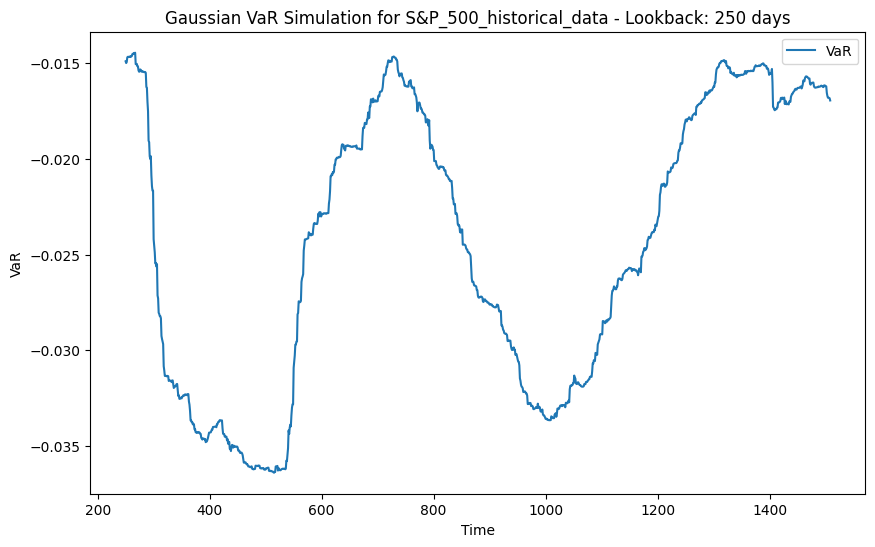

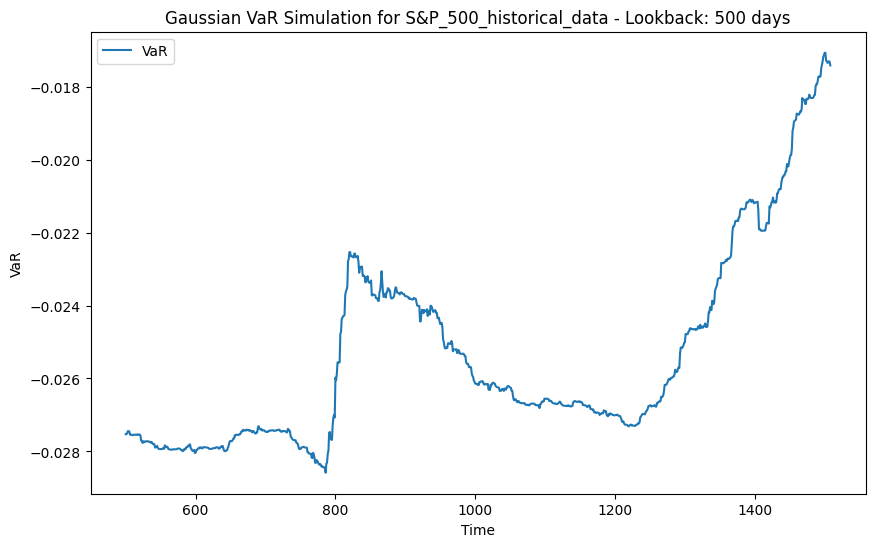

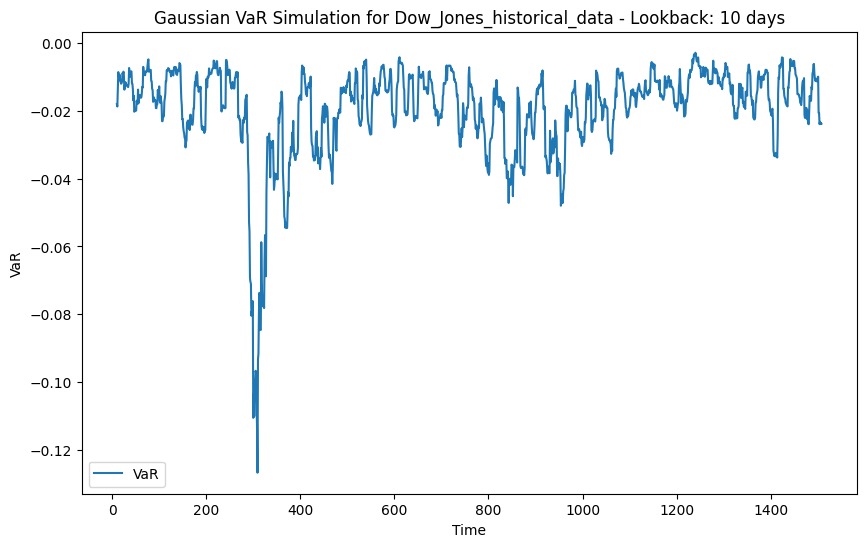

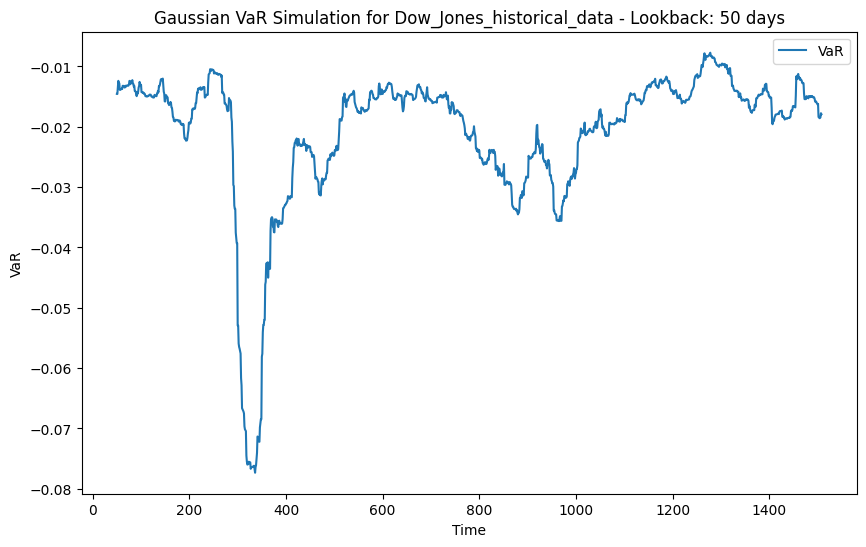

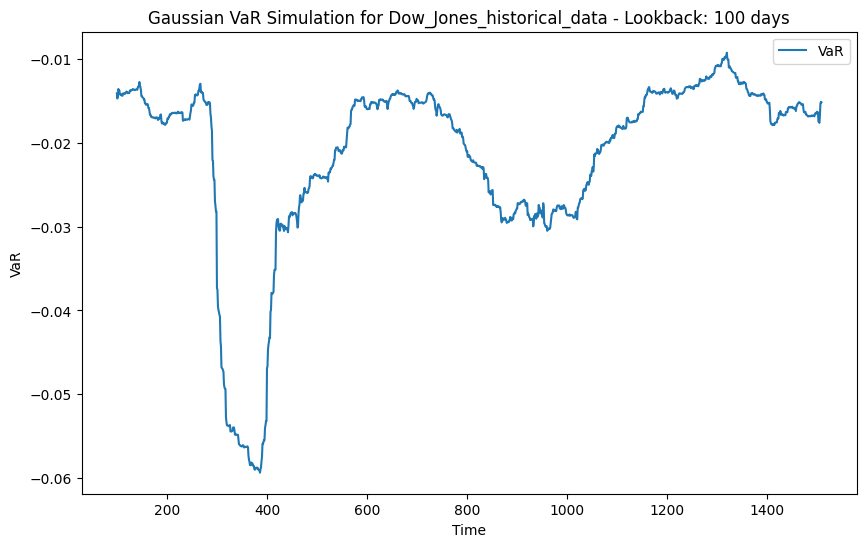

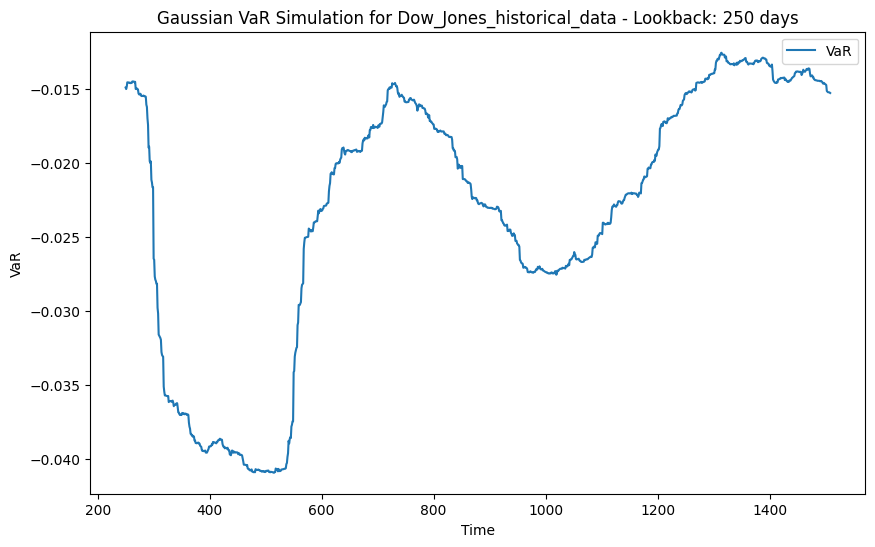

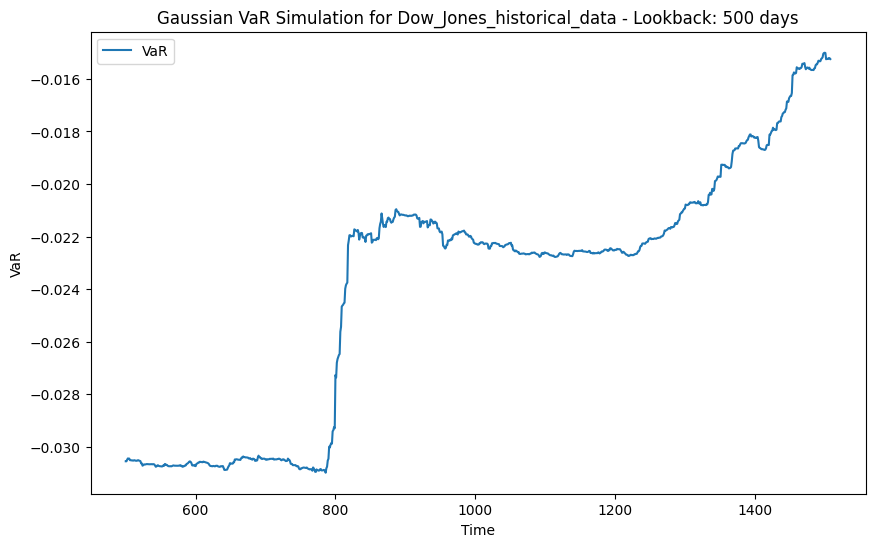

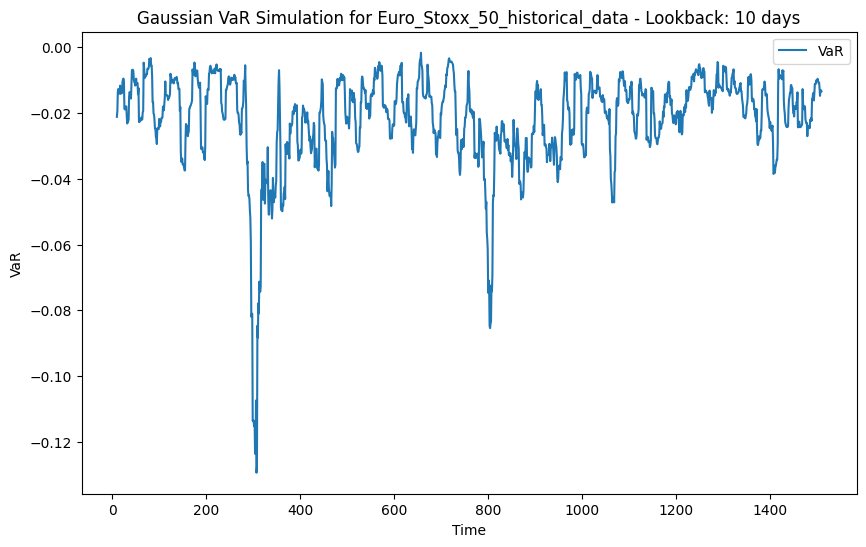

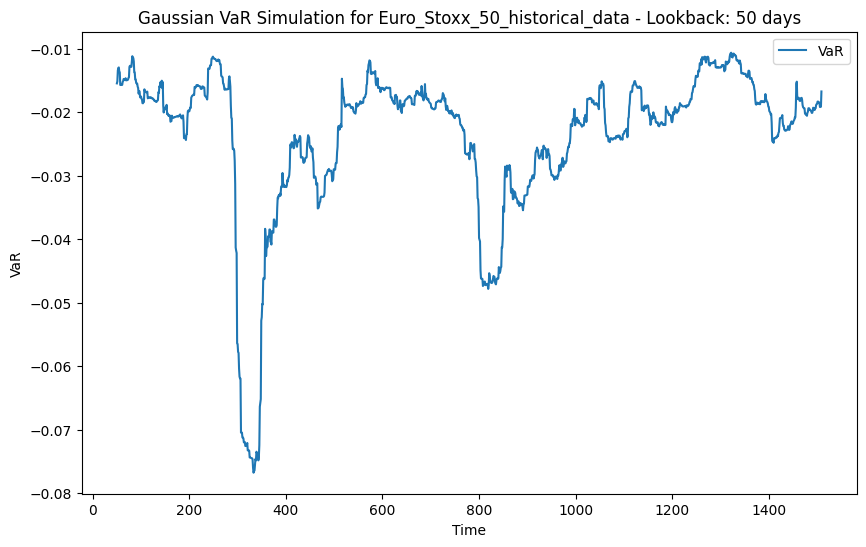

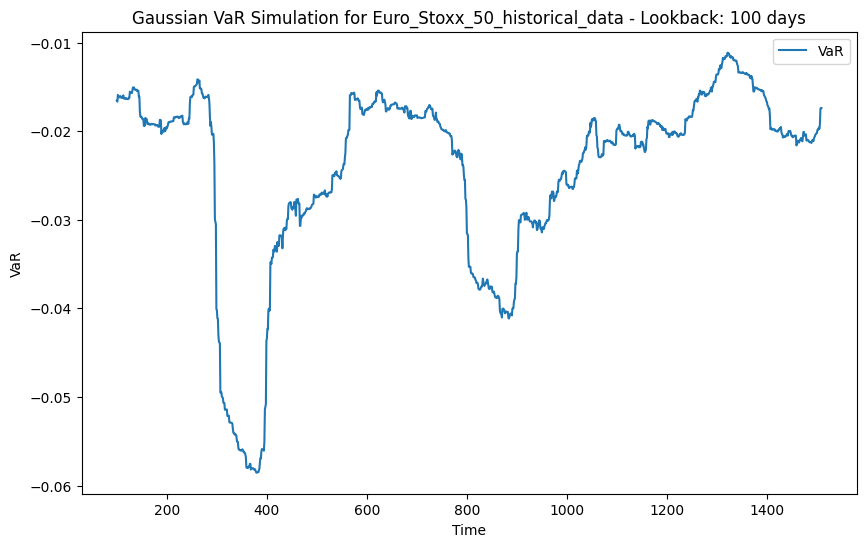

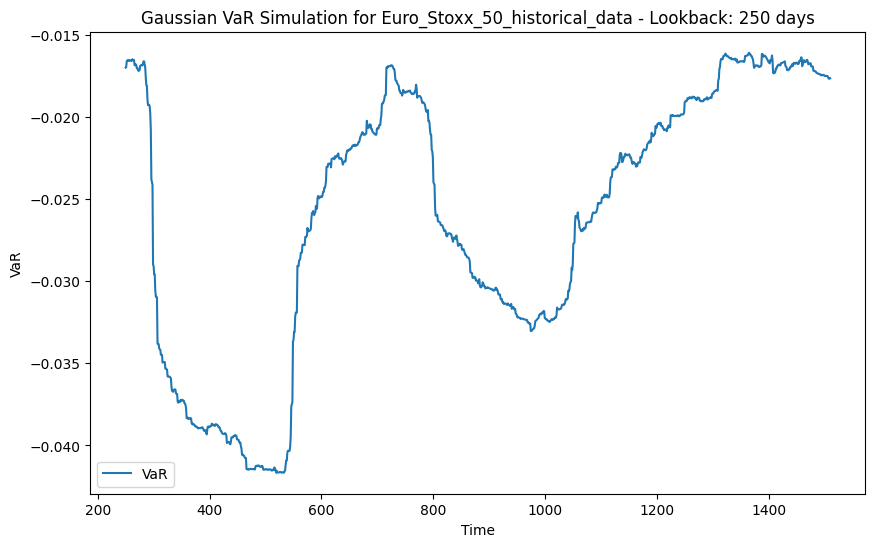

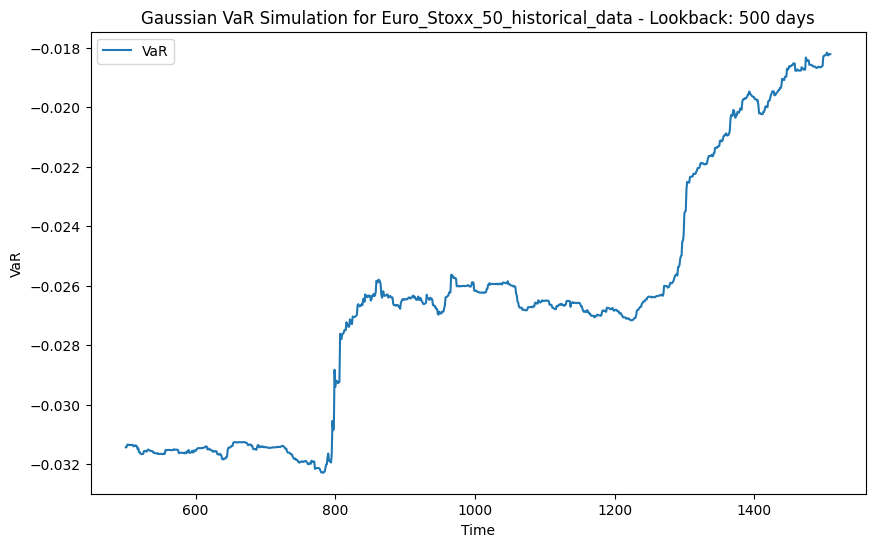

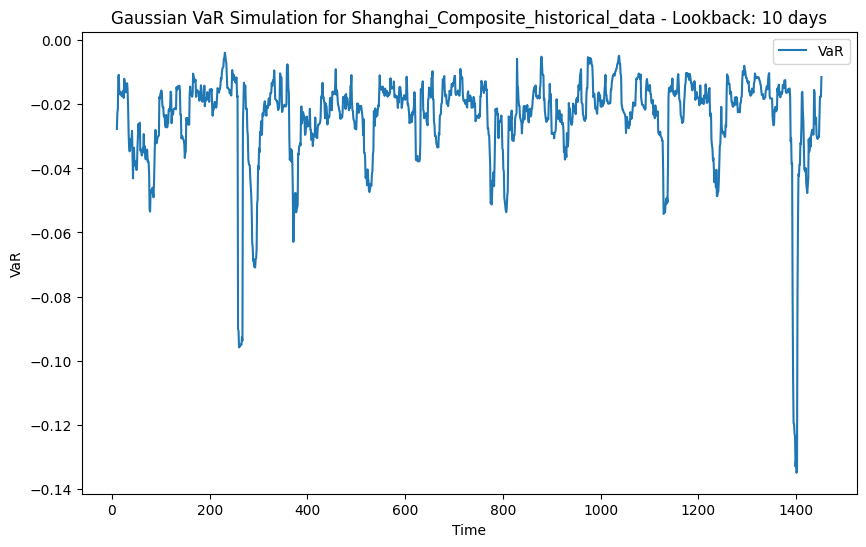

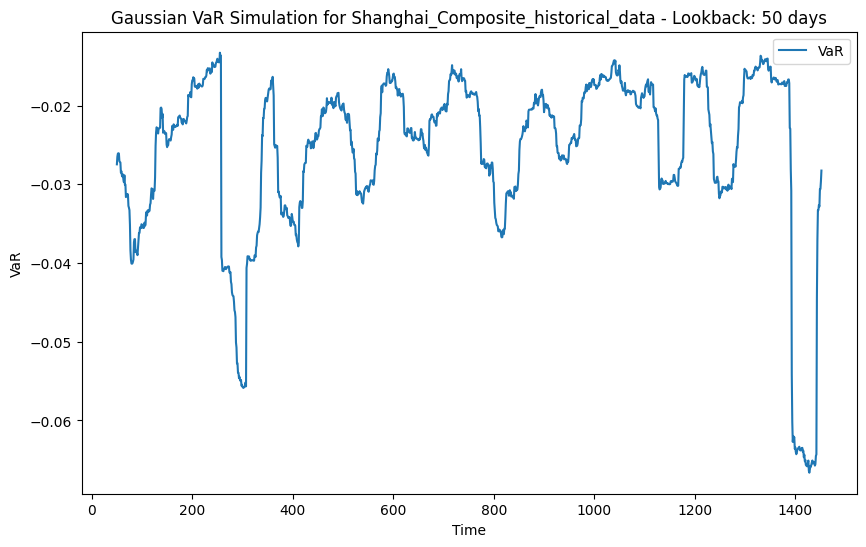

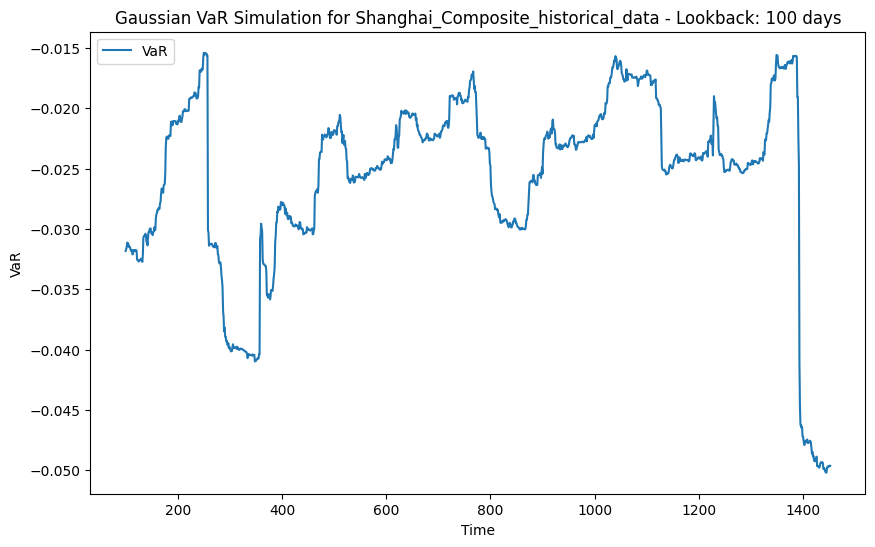

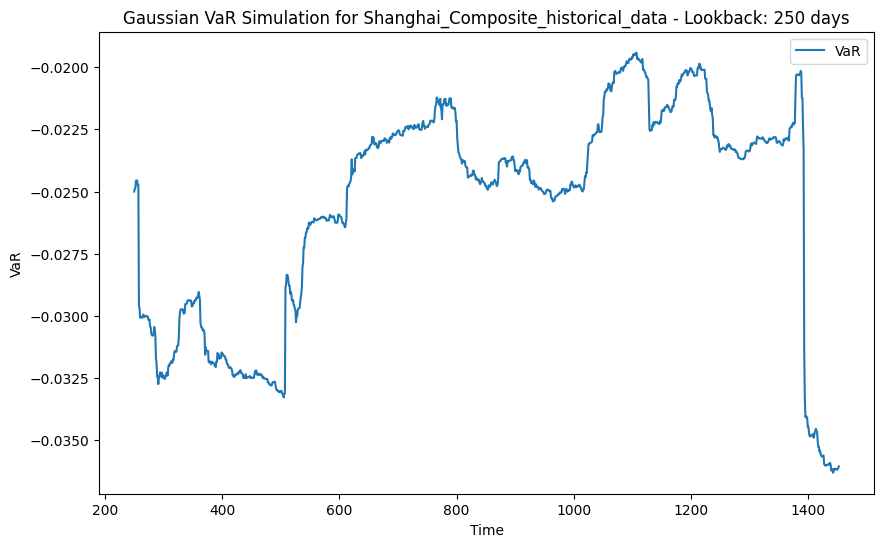

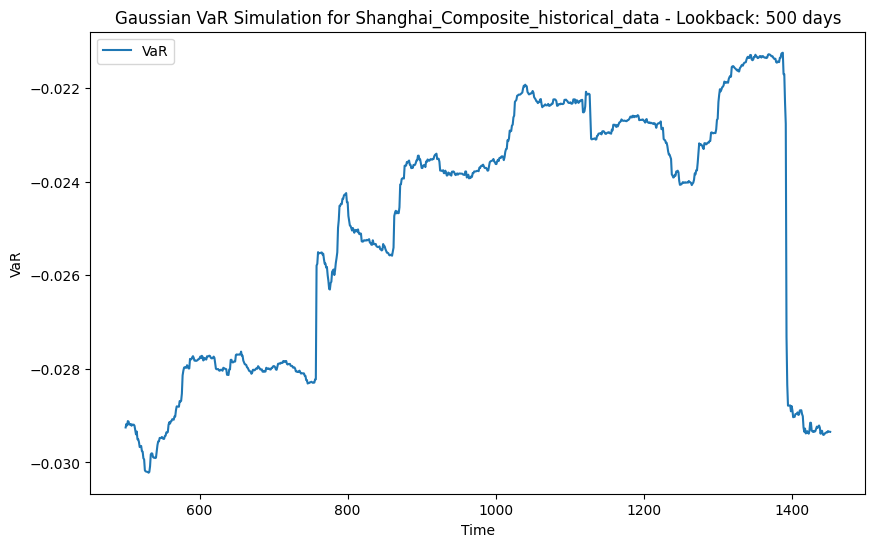

In [42]:
for symbol, period_results in var_results3.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label=f'VaR')
        plt.title(f'Gaussian VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()
        plt.show()
        plt.close()

In [51]:
output_folder = "/content/drive/My Drive/HSBC/obrazki"

os.makedirs(output_folder, exist_ok=True)

for symbol, period_results in var_results3.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label='VaR')
        plt.title(f'Gaussian VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()

        output_path = os.path.join(output_folder, f'{symbol}_Gaussian_VaR_Lookback_{period}_days.png')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()

In [20]:
def filtered_historical_var(dataframes, lookback_periods, confidence_level=0.99, decay_factor=0.94):

    var_results = {}

    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = np.log(data['Close'] / data['Close'].shift(1))
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:

            ewma_volatility = data['return'].ewm(alpha=1-decay_factor, adjust=False).std()

            scaled_returns = data['return'] / ewma_volatility

            scaled_returns.dropna(inplace=True)

            scaled_var = np.percentile(scaled_returns, (1 - confidence_level) * 100)

            var_series = scaled_var * ewma_volatility

            var_series.dropna(inplace=True)

            var_results[symbol][period] = var_series

    return var_results

In [36]:
lookback_periods = [10, 50, 100, 250]
confidence_level = 0.99
decay_factor=0.94
var_results4 = filtered_historical_var(dataframes, lookback_periods = lookback_periods, confidence_level=confidence_level,  decay_factor= decay_factor)

for symbol, period_results in var_results4.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series)

Symbol: S&P_500_historical_data, Lookback: 10 days
2      -0.022683
3      -0.029066
4      -0.024632
5      -0.021381
6      -0.020665
          ...   
1504   -0.021043
1505   -0.020910
1506   -0.020640
1507   -0.020128
1508   -0.021350
Name: return, Length: 1507, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
2      -0.022683
3      -0.029066
4      -0.024632
5      -0.021381
6      -0.020665
          ...   
1504   -0.021043
1505   -0.020910
1506   -0.020640
1507   -0.020128
1508   -0.021350
Name: return, Length: 1507, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
2      -0.022683
3      -0.029066
4      -0.024632
5      -0.021381
6      -0.020665
          ...   
1504   -0.021043
1505   -0.020910
1506   -0.020640
1507   -0.020128
1508   -0.021350
Name: return, Length: 1507, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
2      -0.022683
3      -0.029066
4      -0.024632
5      -0.021381
6      -0.020665
          ...   
15

In [46]:
output_dir = "/content/drive/My Drive/HSBC/FHScsvs"
os.makedirs(output_dir, exist_ok=True)

for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        filename = f"{symbol}_lookback_{period}_days.csv"
        filepath = os.path.join(output_dir, filename)

        series.to_csv(filepath, index=True)
        print(f"Saved: {filepath}")

Saved: /content/drive/My Drive/HSBC/FHScsvs/S&P_500_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/S&P_500_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/S&P_500_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/S&P_500_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/S&P_500_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Dow_Jones_historical_data_lookback_10_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Dow_Jones_historical_data_lookback_50_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Dow_Jones_historical_data_lookback_100_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Dow_Jones_historical_data_lookback_250_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Dow_Jones_historical_data_lookback_500_days.csv
Saved: /content/drive/My Drive/HSBC/FHScsvs/Euro_Stoxx_50_historical_data_lookback_10_days.csv

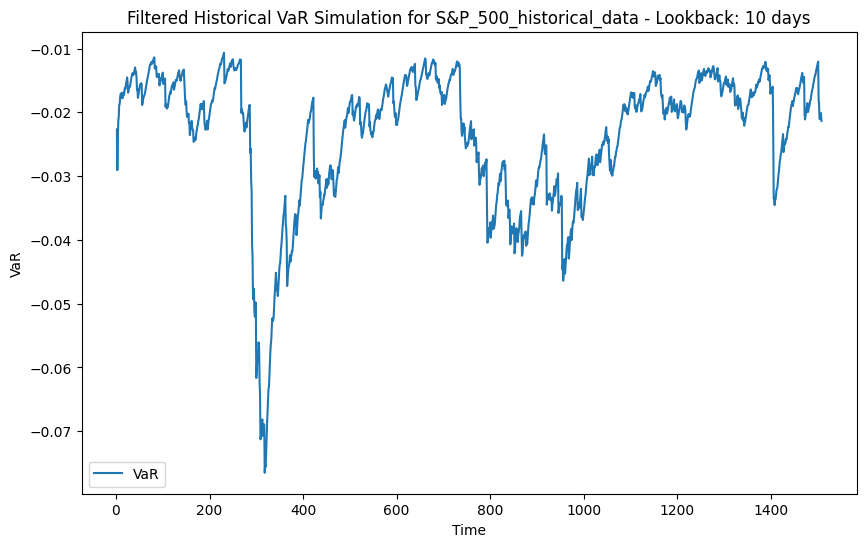

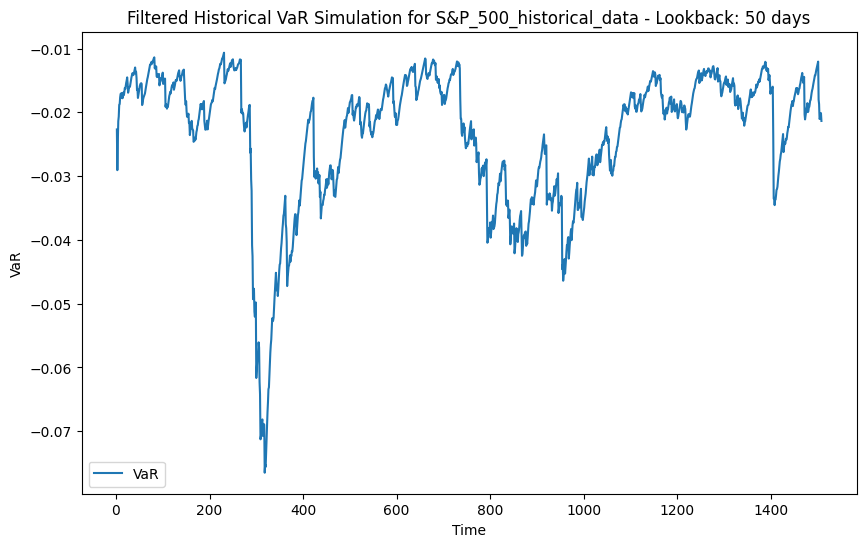

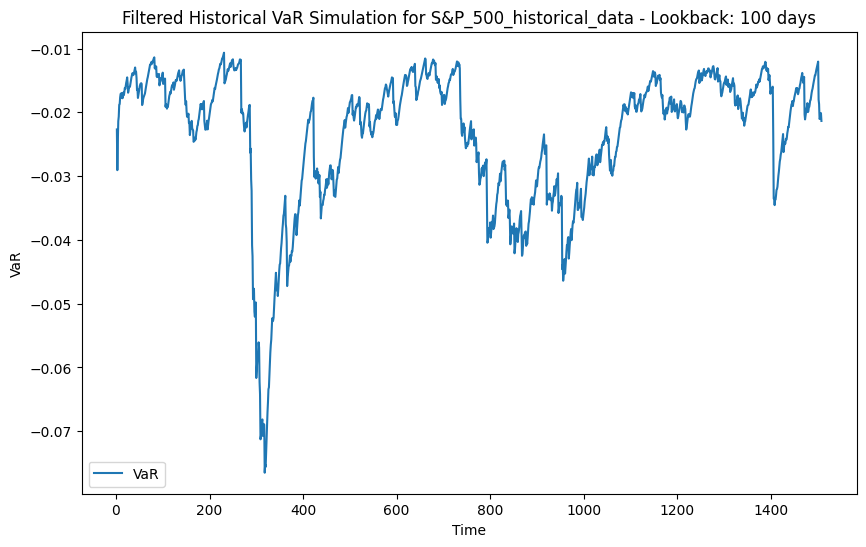

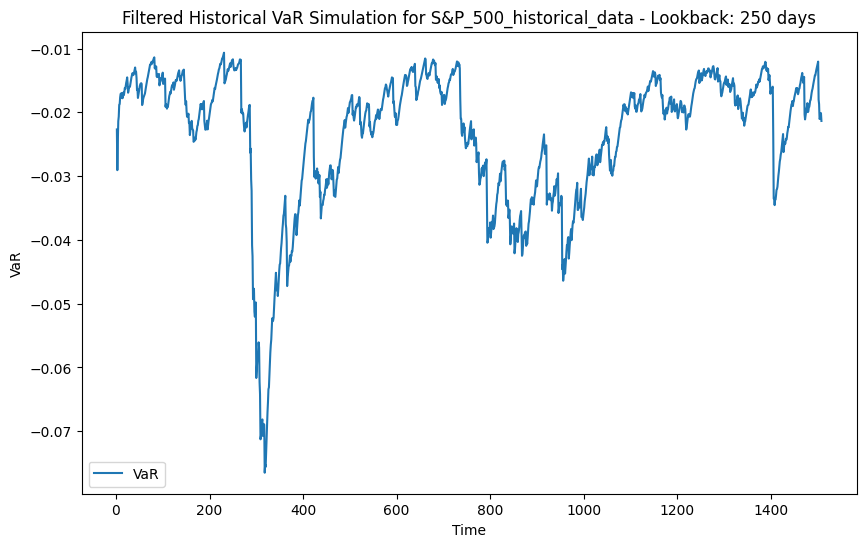

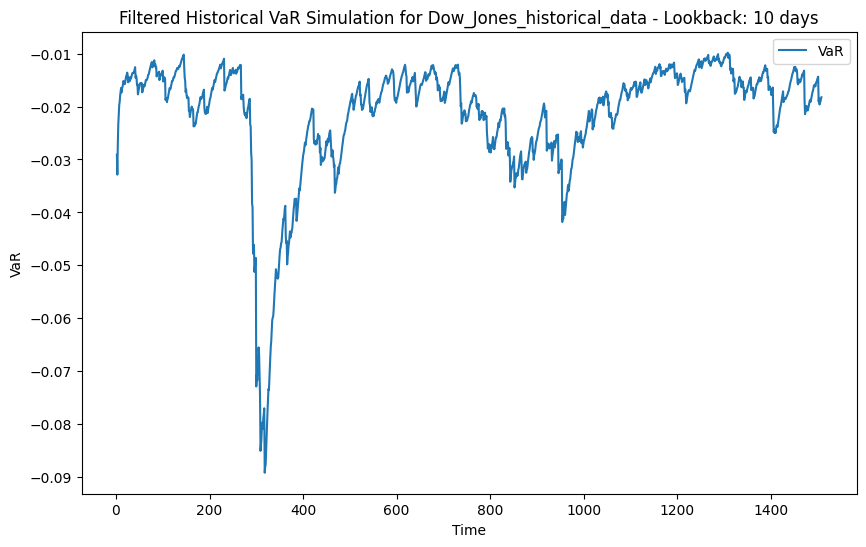

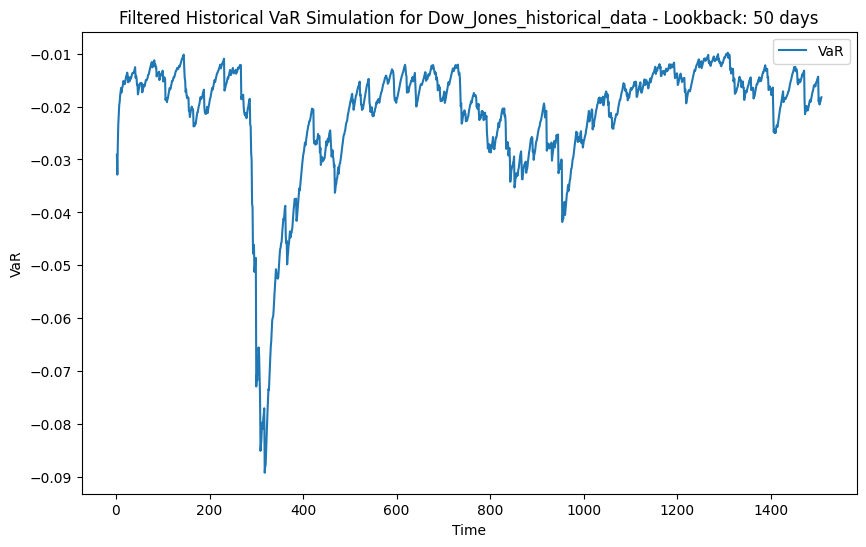

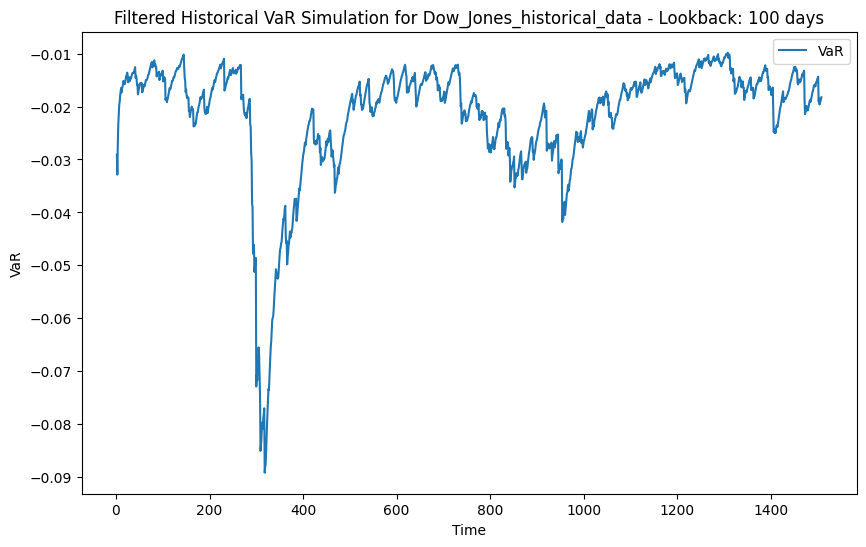

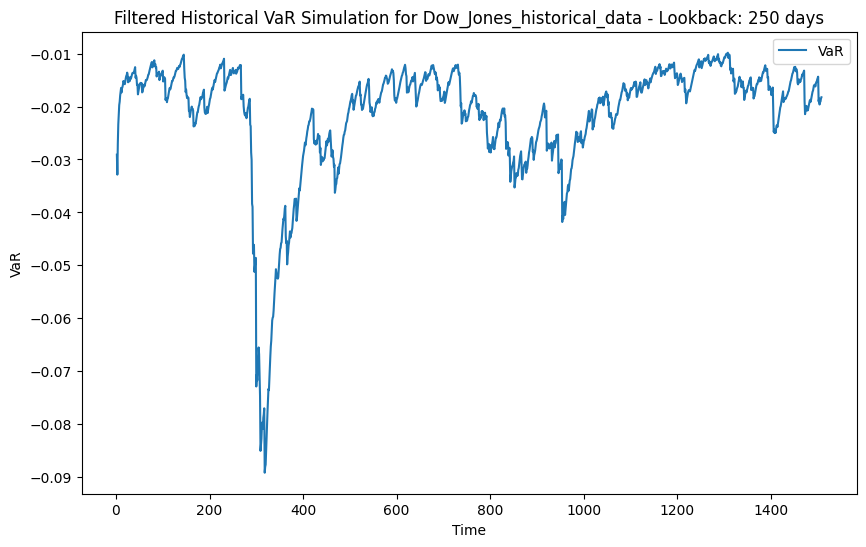

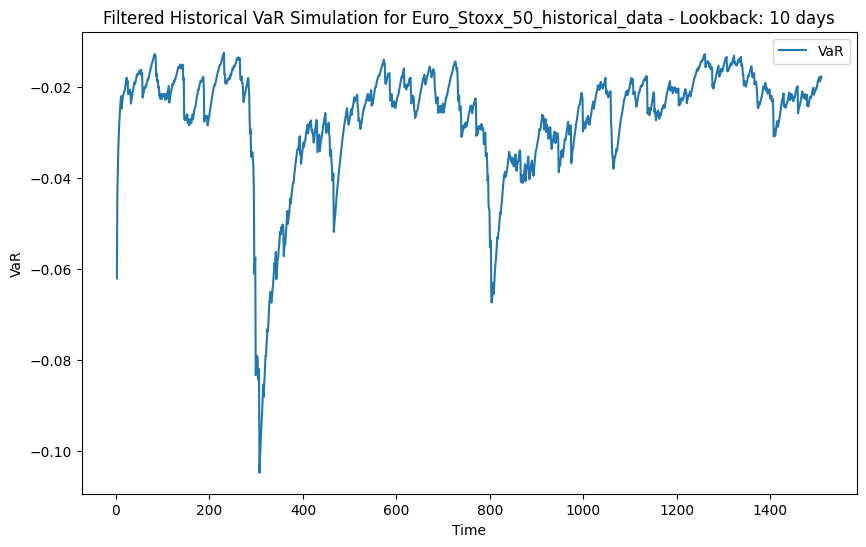

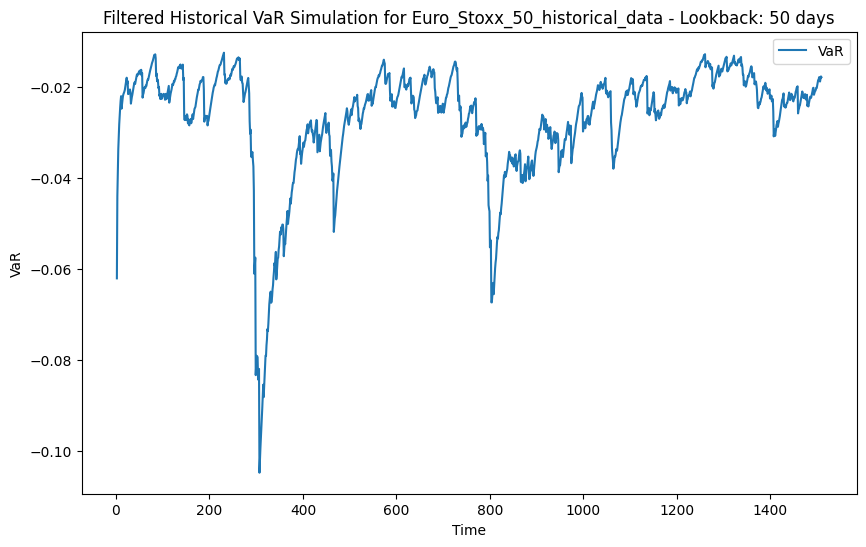

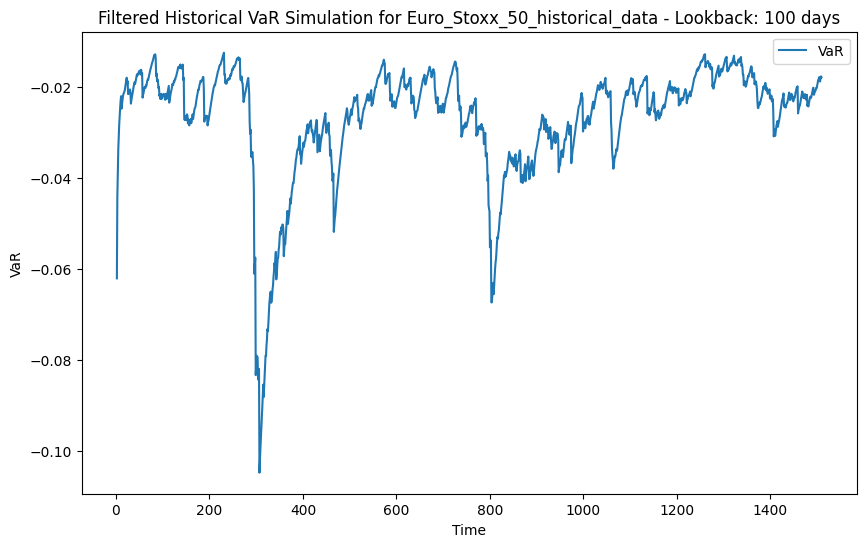

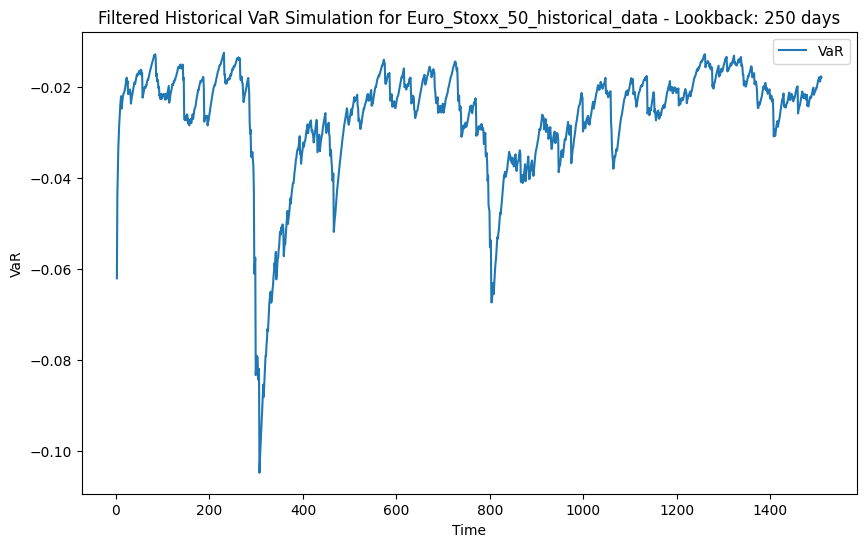

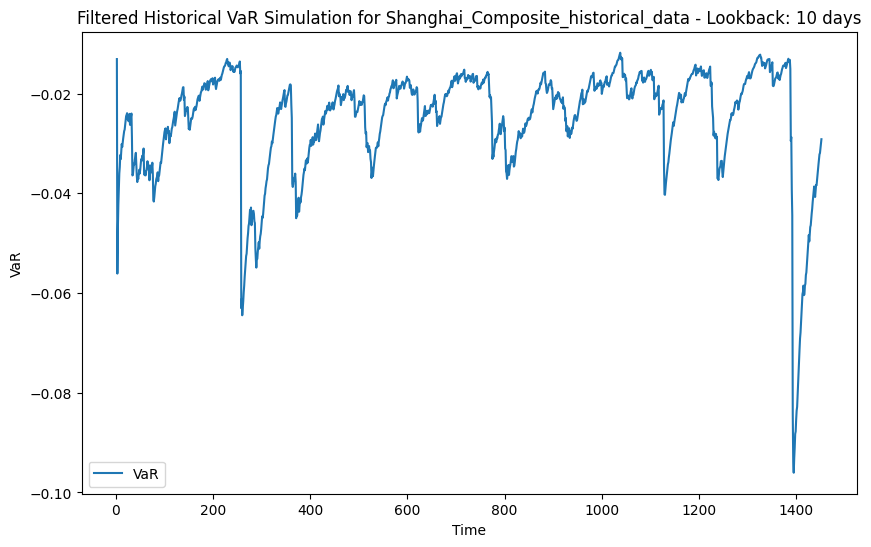

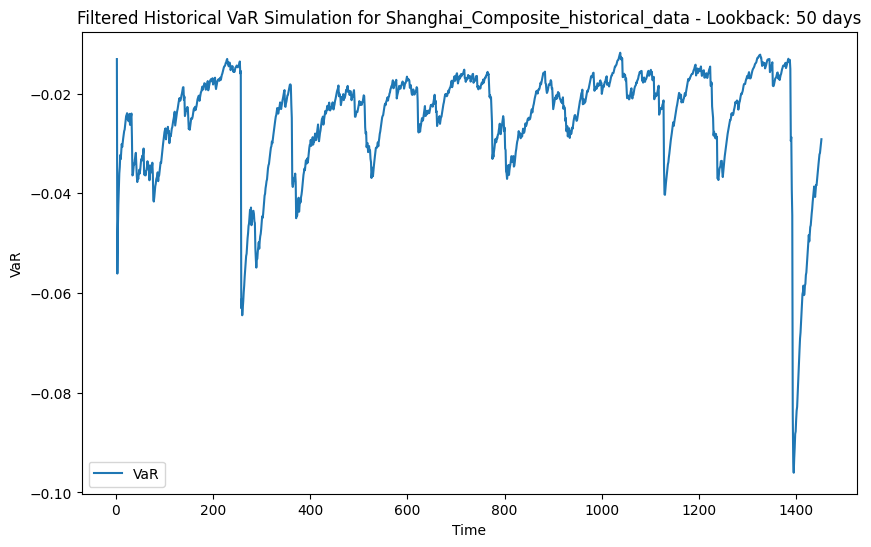

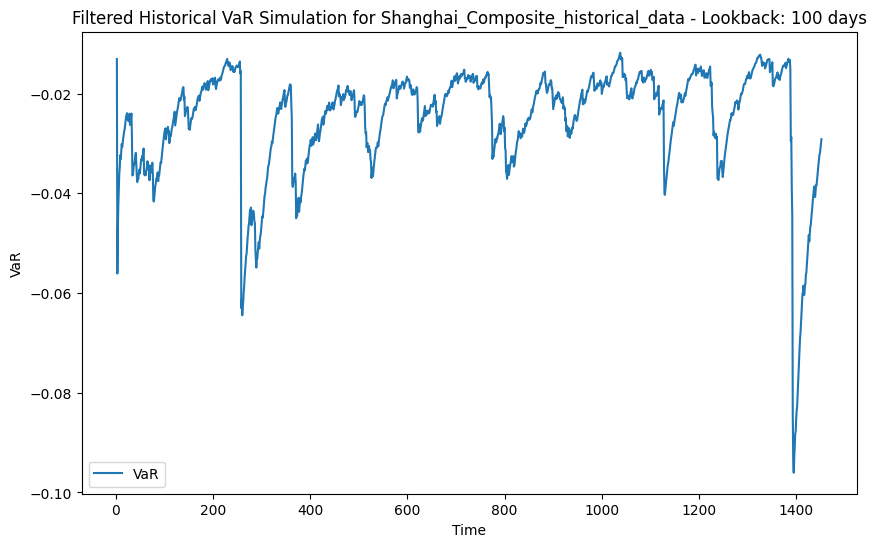

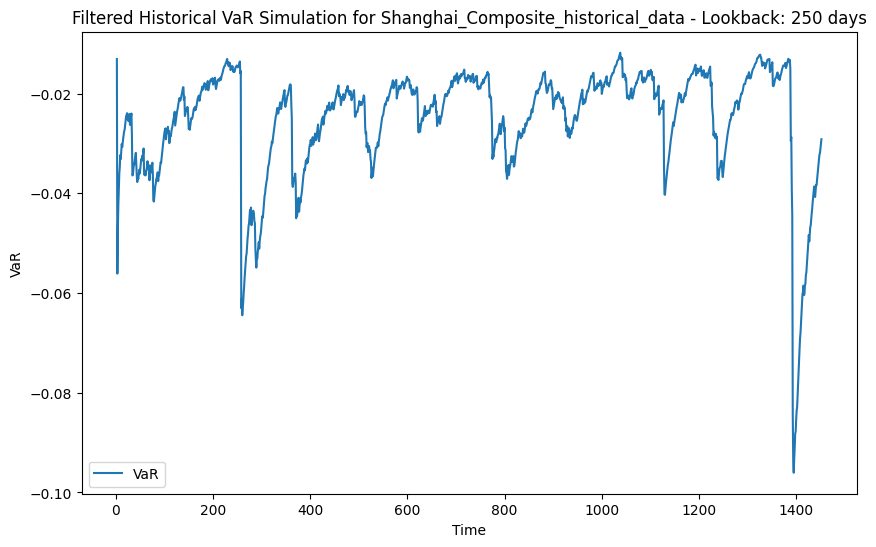

In [43]:
for symbol, period_results in var_results4.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label=f'VaR')
        plt.title(f'Filtered Historical VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()
        plt.show()
        plt.close()

In [52]:
output_folder = "/content/drive/My Drive/HSBC/obrazki"

os.makedirs(output_folder, exist_ok=True)

for symbol, period_results in var_results4.items():
    for period, series in period_results.items():
        plt.figure(figsize=(10, 6))
        plt.plot(series.index, series.values, label='VaR')
        plt.title(f'Filtered Historical VaR Simulation for {symbol} - Lookback: {period} days')
        plt.xlabel('Time')
        plt.ylabel('VaR')
        plt.legend()

        output_path = os.path.join(output_folder, f'{symbol}_Filtered_Historical_VaR_Lookback_{period}_days.png')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()